In [302]:
import matplotlib.pyplot as plt 
import os 
import pandas as pd 
import seaborn as sns 
import numpy as np
import squarify
from django.contrib.admin import display
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, RobustScaler, PowerTransformer
from kmodes.kprototypes import KPrototypes
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


In [303]:
# Load and read all dataset
data_path = "./datasets"

files = []
for dirname, _, filenames in os.walk(data_path):
    for filename in filenames:
        files.append(os.path.join(dirname, filename))

customers_dataset = pd.read_csv(f'{data_path}/olist_customers_dataset.csv')
geolocation_dataset = pd.read_csv(f'{data_path}/olist_geolocation_dataset.csv')
order_items_dataset = pd.read_csv(f'{data_path}/olist_order_items_dataset.csv')
order_payments_dataset = pd.read_csv(f'{data_path}/olist_order_payments_dataset.csv')
order_reviews_dataset = pd.read_csv(f'{data_path}/olist_order_reviews_dataset.csv')
orders_dataset = pd.read_csv(f'{data_path}/olist_orders_dataset.csv')
products_dataset = pd.read_csv(f'{data_path}/olist_products_dataset.csv')
sellers_dataset = pd.read_csv(f'{data_path}/olist_sellers_dataset.csv')

In [304]:
# Check data sanity (entries and columns)
print("Customers Dataset: ", customers_dataset.shape)
print("Geolocation Dataset: ", geolocation_dataset.shape)
print("Order Items Dataset: ", order_items_dataset.shape)
print("Order Payments Dataset: ", order_payments_dataset.shape)
print("Order Reviews Dataset: ", order_reviews_dataset.shape)
print("Orders Dataset: ", orders_dataset.shape)
print("Products Dataset: ", products_dataset.shape)
print("Sellers Dataset: ", sellers_dataset.shape)

Customers Dataset:  (99441, 5)
Geolocation Dataset:  (1000163, 5)
Order Items Dataset:  (112650, 7)
Order Payments Dataset:  (103886, 5)
Order Reviews Dataset:  (99224, 7)
Orders Dataset:  (99441, 8)
Products Dataset:  (32951, 9)
Sellers Dataset:  (3095, 4)


Karena segmentasi yang akan dilakukan yaitu customer segmentation, maka preprocessing akan difokuskan pada data yang berkaitan dengan customer terlebih dahulu

In [305]:
def check_info(title, data):
    print(title)
    display(data.head())
    print(data.info())
    display(data.describe(include='all'))
    print(f"Missing values count: {data.isnull().sum().sum()}\n")

check_info("Customer dataset:", customers_dataset)
check_info("Order items dataset:", order_items_dataset)
check_info("Order payments dataset:", order_payments_dataset)
check_info("Orders dataset:", orders_dataset)

Customer dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None
Missing values count: 0

Order items dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            1126

Ditemukan adanya missing values pada dataset orders

In [306]:
# check null values
print("Column name | Count of missing values | Total row | Percentage")
null = orders_dataset.isnull().sum()[orders_dataset.isnull().sum() > 0]
print(np.array(
    [null.index, null.values, [orders_dataset.shape[0]] * len(null), null.values / orders_dataset.shape[0] * 100]).T)
# check the data
display(orders_dataset[orders_dataset.isnull().any(axis=1)].head())
# check order status of missing values
print(orders_dataset[orders_dataset.isnull().any(axis=1)]['order_status'].value_counts())

Column name | Count of missing values | Total row | Percentage
[['order_approved_at' 160 99441 0.1608994278014099]
 ['order_delivered_carrier_date' 1783 99441 1.7930229985619612]
 ['order_delivered_customer_date' 2965 99441 2.981667521444877]]
order_status
shipped        1107
canceled        619
unavailable     609
invoiced        314
processing      301
delivered        23
created           5
approved          2
Name: count, dtype: int64


In [307]:
print("total entry before delete: ", orders_dataset.shape[0])
orders_dataset = orders_dataset.dropna(subset=['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date'])
print("total row after delete: ", orders_dataset.shape[0])
orders_dataset.info()
orders_dataset.isnull().sum()

total entry before delete:  99441
total row after delete:  96461
<class 'pandas.core.frame.DataFrame'>
Index: 96461 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       96461 non-null  object
 1   customer_id                    96461 non-null  object
 2   order_status                   96461 non-null  object
 3   order_purchase_timestamp       96461 non-null  object
 4   order_approved_at              96461 non-null  object
 5   order_delivered_carrier_date   96461 non-null  object
 6   order_delivered_customer_date  96461 non-null  object
 7   order_estimated_delivery_date  96461 non-null  object
dtypes: object(8)
memory usage: 6.6+ MB


order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
dtype: int64

Lanjut preprocessing, fix data types dan standardize categorical variables

In [308]:
# convert datetime string on orders_dataset dataset to datetime type
orders_dataset['order_purchase_timestamp'] = pd.to_datetime(orders_dataset['order_purchase_timestamp'])
orders_dataset['order_approved_at'] = pd.to_datetime(orders_dataset['order_approved_at'])
orders_dataset['order_delivered_carrier_date'] = pd.to_datetime(orders_dataset['order_delivered_carrier_date'])
orders_dataset['order_delivered_customer_date'] = pd.to_datetime(orders_dataset['order_delivered_customer_date'])
orders_dataset['order_estimated_delivery_date'] = pd.to_datetime(orders_dataset['order_estimated_delivery_date'])
display(orders_dataset.head())
orders_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96461 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       96461 non-null  object        
 1   customer_id                    96461 non-null  object        
 2   order_status                   96461 non-null  object        
 3   order_purchase_timestamp       96461 non-null  datetime64[ns]
 4   order_approved_at              96461 non-null  datetime64[ns]
 5   order_delivered_carrier_date   96461 non-null  datetime64[ns]
 6   order_delivered_customer_date  96461 non-null  datetime64[ns]
 7   order_estimated_delivery_date  96461 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.6+ MB


In [309]:
# convert datetime string on order_item dataset to datetime type
order_items_dataset['shipping_limit_date'] = pd.to_datetime(order_items_dataset['shipping_limit_date'])
print(order_items_dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB
None


In [310]:
# convert order_status on order dataset to category type
orders_dataset['order_status'] = orders_dataset['order_status'].astype('category')
orders_dataset['order_status'].value_counts()

order_status
delivered    96455
canceled         6
Name: count, dtype: int64

In [311]:
# standardize order status using label encoding
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
orders_dataset['order_status_encoded'] = le.fit_transform(orders_dataset['order_status'])

status_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(f"Order status mapping: {status_mapping}")

Order status mapping: {'canceled': np.int64(0), 'delivered': np.int64(1)}


In [312]:
# standardize payment type using one hot encoding
payment_dummies = pd.get_dummies(order_payments_dataset['payment_type'], prefix='payment')
payments = pd.concat([order_payments_dataset, payment_dummies], axis=1)
# payments.drop(columns='payment_type', inplace=True)
payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value,payment_boleto,payment_credit_card,payment_debit_card,payment_not_defined,payment_voucher
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,False,True,False,False,False
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39,False,True,False,False,False
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71,False,True,False,False,False
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78,False,True,False,False,False
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45,False,True,False,False,False


---

null on customer city:  0.0
accent on customer city:  0


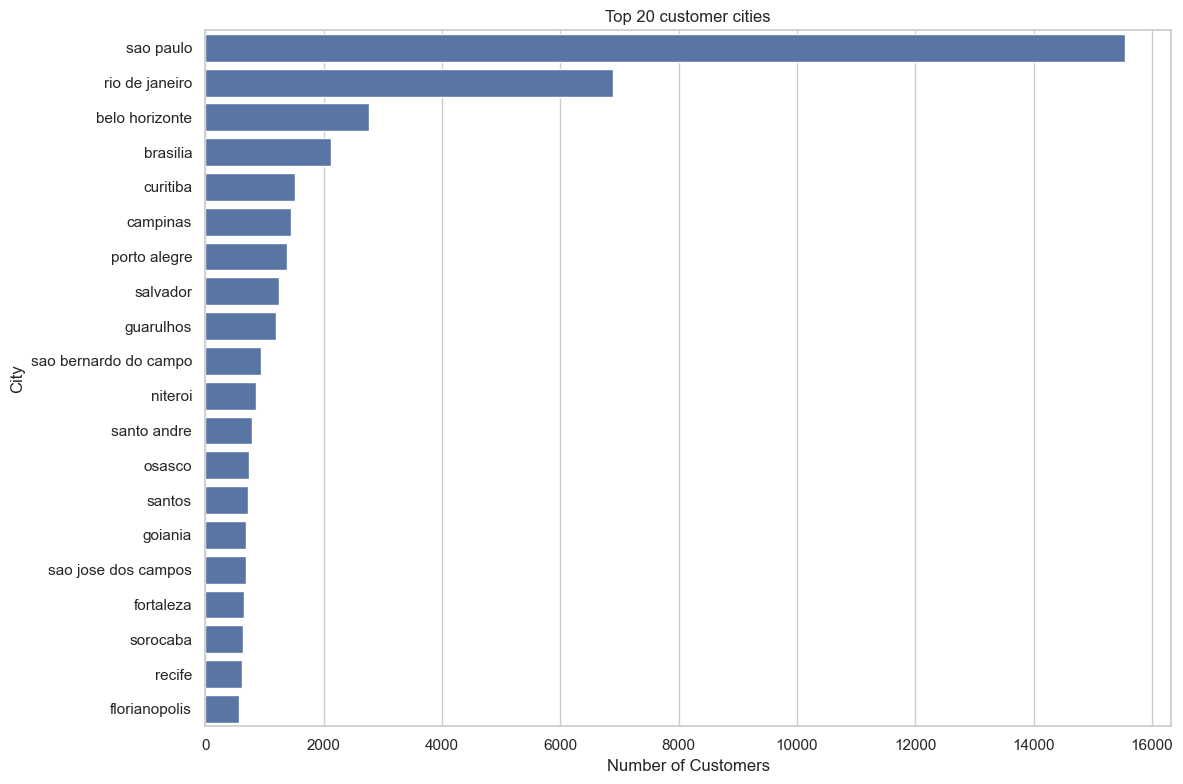

In [313]:
# top 20 customer cities
import unidecode
import re
print("null on customer city: ", customers_dataset['customer_city'].isna().mean())

# karena kota di brazil kemungkinan ada huruf dengan aksen dan ada kemungkinan duplikat dengan non-aksen, periksa terlebih dahulu 
def has_accented_characters(s):
    return bool(re.search(r'[^\x00-\x7F]', s))

print("accent on customer city: ", customers_dataset['customer_city'].apply(has_accented_characters).sum())

customer_city_counts = customers_dataset['customer_city'].value_counts().reset_index()
customer_city_counts.columns = ['City', 'Count']

top_20_cities = customer_city_counts.head(20)
# Plot using bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='City', data=top_20_cities)
plt.title('Top 20 customer cities')
plt.xlabel('Number of Customers')
plt.ylabel('City')
plt.tight_layout()
plt.show()

In [314]:
# heatmap customer
print("null in geolocation dataset: \n", geolocation_dataset.isna().mean())
print("unique val in geoloc: ", geolocation_dataset['geolocation_city'].unique())
def has_accented_characters(s):
    return bool(re.search(r'[^\x00-\x7F]', s))

print("accent on geolocation city: ", geolocation_dataset['geolocation_city'].apply(has_accented_characters).sum())
# karena ada kota dengan huruf aksen dan non-aksen duplikat, perlu dilakukan preprocessing terlebih dahulu
def pretty_string(column):
    column_space = ' '.join(column.split())
    return unidecode.unidecode(column_space.lower())
geolocation_dataset['geolocation_city'] = geolocation_dataset['geolocation_city'].apply(pretty_string)
print("unique val in geoloc: ", geolocation_dataset['geolocation_city'].unique())
print("accent on geolocation city: ", geolocation_dataset['geolocation_city'].apply(has_accented_characters).sum())

null in geolocation dataset: 
 geolocation_zip_code_prefix    0.0
geolocation_lat                0.0
geolocation_lng                0.0
geolocation_city               0.0
geolocation_state              0.0
dtype: float64
unique val in geoloc:  ['sao paulo' 'são paulo' 'sao bernardo do campo' ... 'ciríaco' 'estação'
 'vila lângaro']
accent on geolocation city:  73442
unique val in geoloc:  ['sao paulo' 'sao bernardo do campo' 'jundiai' ... 'floriano peixoto'
 'erebango' 'santa cecilia do sul']
accent on geolocation city:  0


geolocation_zip_code_prefix
24220    1146
24230    1102
38400     965
35500     907
11680     879
         ... 
1200        1
1189        1
1290        1
1262        1
39523       1
Length: 19015, dtype: int64
        geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
470805                        24220       -22.905817       -43.106989   
470811                        24220       -22.902306       -43.112545   
470812                        24220       -22.904567       -43.110491   
470820                        24220       -22.902575       -43.109192   
470821                        24220       -22.907500       -43.106170   

       geolocation_city geolocation_state  
470805          niteroi                RJ  
470811          niteroi                RJ  
470812          niteroi                RJ  
470820          niteroi                RJ  
470821          niteroi                RJ  
(8, 2)


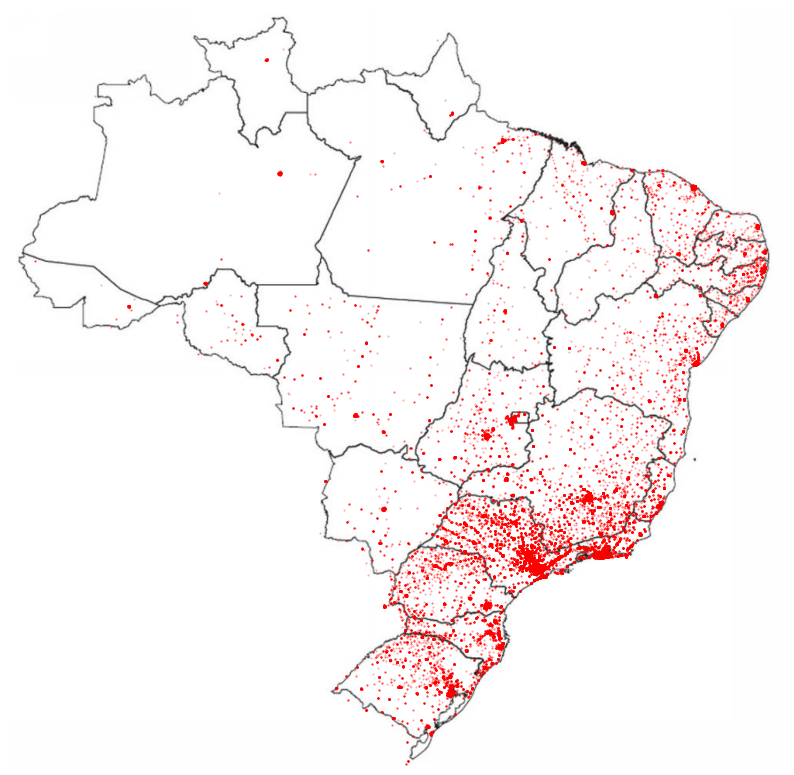

In [315]:
# heatmap customer lanjut part 2
import urllib
from matplotlib import image as mpimg
# cek zipcode
print(geolocation_dataset.groupby('geolocation_zip_code_prefix').size().sort_values(ascending=False))
# karena zipcode pada data di-hide sehingga hanya prefix nya saja yang dimunculkan, ada kemungkinan satu zipcode prefix memiliki beberapa koordinat, sesuai dengan zipcode lengkapnya
print(geolocation_dataset[geolocation_dataset['geolocation_zip_code_prefix'] == 24220].head())
# oleh karena itu perlu dilakukan data processing dengan mengambil titik tengah dari masing2 zipcode prefix
state_unique_geolocation = geolocation_dataset.groupby(['geolocation_zip_code_prefix'])['geolocation_state'].nunique().reset_index(name='count')
print(state_unique_geolocation[state_unique_geolocation['count']>= 2].shape)
max_state = geolocation_dataset.groupby(['geolocation_zip_code_prefix','geolocation_state']).size().reset_index(name='count').drop_duplicates(subset = 'geolocation_zip_code_prefix').drop('count',axis=1)
geolocation_coords = geolocation_dataset.groupby(['geolocation_zip_code_prefix','geolocation_city','geolocation_state'])[['geolocation_lat','geolocation_lng']].median().reset_index()
geolocation_coords = geolocation_coords.merge(max_state,on=['geolocation_zip_code_prefix','geolocation_state'],how='inner')
customers_coords = customers_dataset.merge(geolocation_coords,left_on='customer_zip_code_prefix',right_on='geolocation_zip_code_prefix',how='inner')
# mari mapping 
brazil = mpimg.imread(urllib.request.urlopen('https://i.pinimg.com/originals/3a/0c/e1/3a0ce18b3c842748c255bc0aa445ad41.jpg'),'jpg')
ax = customers_coords.drop_duplicates(subset='customer_unique_id').plot(kind="scatter", x="geolocation_lng", y="geolocation_lat", figsize=(10,10), alpha=0.3,s=0.3,c='red')
plt.axis('off')
plt.imshow(brazil, extent=[-73.98283055, -33.8,-33.75116944,5.4])
plt.show()

In [316]:
# alternatif heatmap yang sinan pengen
import folium
from folium.plugins import HeatMap

customer_counts = customers_coords.groupby(['geolocation_lat', 'geolocation_lng']).size().reset_index(name='customer_count')

# Create a map centered on Brazil
brazil_map = folium.Map(location=[-15.77972, -47.92972], zoom_start=4)

# Add heatmap layer
heat_data = [[row['geolocation_lat'], row['geolocation_lng'], row['customer_count']]
             for index, row in customer_counts.iterrows()]
HeatMap(heat_data).add_to(brazil_map)
display(brazil_map)

                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15

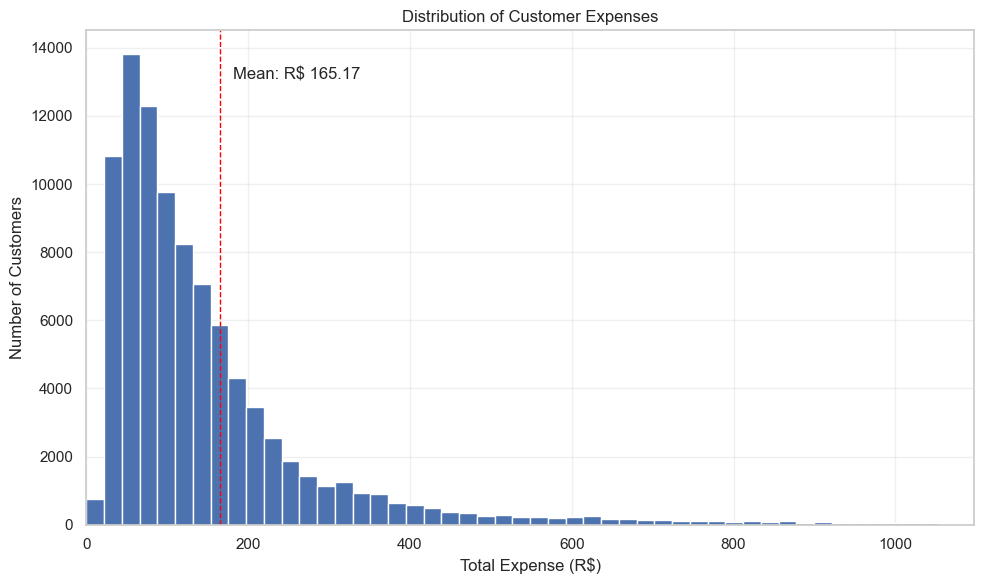

In [317]:
# average expense of a customer
orders_with_customers = pd.merge(orders_dataset, customers_dataset, on='customer_id')
orders_with_items = pd.merge(orders_with_customers, order_items_dataset, on='order_id')
print(orders_with_items.head())

# total expense per customer (unique_id)
orders_with_items['total_value'] = orders_with_items['price'] + orders_with_items['freight_value']
customer_expenses = orders_with_items.groupby('customer_unique_id')['total_value'].sum().reset_index()
customer_expenses.columns = ['Customer ID', 'Total Expense']
print(customer_expenses.head())

# average customer expense
avg_expense = customer_expenses['Total Expense'].mean()
print(f"Average customer expense: R$ {avg_expense:.2f}")

# some additional statistics
perc_99 = np.percentile(customer_expenses['Total Expense'], 99)
print(f"Median customer expense: R$ {customer_expenses['Total Expense'].median():.2f}")
print(f"Maximum customer expense: R$ {customer_expenses['Total Expense'].max():.2f}")
print(f"99th percentile expense: R$ {perc_99:.2f}")

# histogram
# karena adanya outlier yang membuat histogram sebelumnya terlihat terlalu lebar, maka range histogram akan di set ke max 99th percentile saja
plt.figure(figsize=(10, 6))
plt.hist(customer_expenses['Total Expense'], bins=50, range=(0, perc_99))
plt.axvline(avg_expense, color='red', linestyle='dashed', linewidth=1)
plt.text(avg_expense*1.1, plt.ylim()[1]*0.9, f'Mean: R$ {avg_expense:.2f}')
plt.title('Distribution of Customer Expenses')
plt.xlabel('Total Expense (R$)')
plt.ylabel('Number of Customers')
plt.xlim(0, perc_99)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Order count per year
   year  order_count
0  2016          272
1  2017        43411
2  2018        52778
Average monthly orders: 4193.96
Average yearly orders: 32153.67


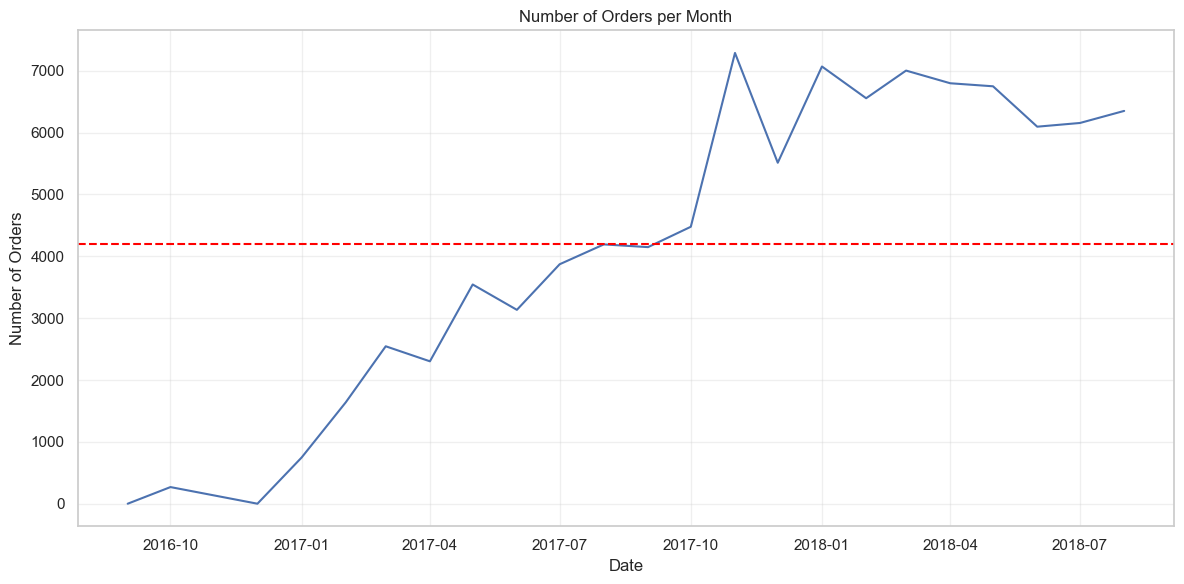

In [318]:
# average order in a year
orders_dataset['year'] = orders_dataset['order_purchase_timestamp'].dt.year
orders_dataset['month'] = orders_dataset['order_purchase_timestamp'].dt.month

monthly_orders = orders_dataset.groupby(['year', 'month']).size().reset_index(name='order_count')
monthly_orders['date'] = pd.to_datetime(monthly_orders['year'].astype(str) + '-' + monthly_orders['month'].astype(str) + '-01')
monthly_orders = monthly_orders.sort_values('date')

yearly_orders = orders_dataset.groupby(['year']).size().reset_index(name='order_count')
print("Order count per year")
print(yearly_orders)

avg_monthly_orders = monthly_orders['order_count'].mean()
print(f"Average monthly orders: {avg_monthly_orders:.2f}")
avg_yearly_orders = yearly_orders['order_count'].mean()
print(f"Average yearly orders: {avg_yearly_orders:.2f}")

plt.figure(figsize=(12, 6))
plt.plot(monthly_orders['date'], monthly_orders['order_count'])
plt.axhline(avg_monthly_orders, color='red', linestyle='dashed')
plt.title('Number of Orders per Month')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

payment_type
credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: count, dtype: int64


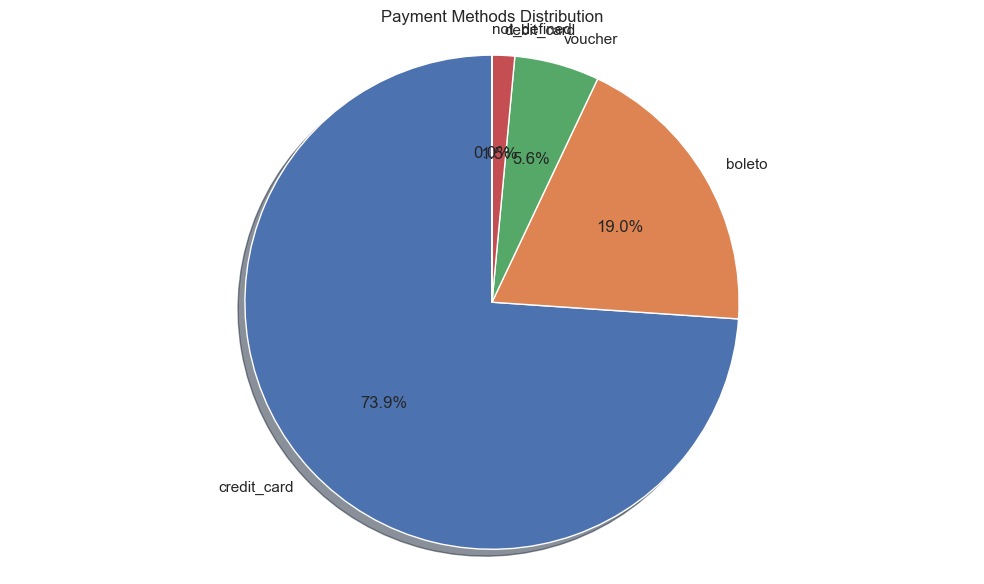

  Payment Method  Percentage
0    credit_card   73.922376
1         boleto   19.043952
2        voucher    5.558978
3     debit_card    1.471806
4    not_defined    0.002888


In [319]:
payment_counts = order_payments_dataset['payment_type'].value_counts()
print(payment_counts)

payment_percentages = (payment_counts / payment_counts.sum() * 100).reset_index()
payment_percentages.columns = ['Payment Method', 'Percentage']

plt.figure(figsize=(10, 6))
plt.pie(payment_percentages['Percentage'], labels=payment_percentages['Payment Method'],
        autopct='%1.1f%%', startangle=90, shadow=True)
plt.axis('equal')
plt.title('Payment Methods Distribution')
plt.tight_layout()
plt.show()

print(payment_percentages)

---

# Merge Customer, Order, and Payment Data Frane

In [320]:
#Merging all relevant datasets
merged_ds = pd.merge(customers_dataset, orders_dataset, on='customer_id', how='inner')
merged_ds = pd.merge(merged_ds, order_items_dataset, on='order_id', how='inner')
merged_ds = pd.merge(merged_ds, order_payments_dataset, on='order_id', how='inner')

In [321]:
# Shape 
print(merged_ds.shape)

(115018, 25)


In [322]:
# Info
print(merged_ds.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115018 entries, 0 to 115017
Data columns (total 25 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    115018 non-null  object        
 1   customer_unique_id             115018 non-null  object        
 2   customer_zip_code_prefix       115018 non-null  int64         
 3   customer_city                  115018 non-null  object        
 4   customer_state                 115018 non-null  object        
 5   order_id                       115018 non-null  object        
 6   order_status                   115018 non-null  category      
 7   order_purchase_timestamp       115018 non-null  datetime64[ns]
 8   order_approved_at              115018 non-null  datetime64[ns]
 9   order_delivered_carrier_date   115018 non-null  datetime64[ns]
 10  order_delivered_customer_date  115018 non-null  datetime64[ns]
 11  

# Cleaning Data

In [323]:
# Convert datetime columns to datetime type
merged_ds['order_purchase_timestamp'] = pd.to_datetime(merged_ds['order_purchase_timestamp'])

In [324]:
# filter out rows that are not delivered (incomplete)
merged_ds = merged_ds[merged_ds['order_status'] == 'delivered'].copy()

In [325]:
# Count missing values
print("Missing values count:\n", merged_ds.isnull().sum())

Missing values count:
 customer_id                      0
customer_unique_id               0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
order_id                         0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
order_status_encoded             0
year                             0
month                            0
order_item_id                    0
product_id                       0
seller_id                        0
shipping_limit_date              0
price                            0
freight_value                    0
payment_sequential               0
payment_type                     0
payment_installments             0
payment_value                    0
dtype: int64


In [326]:
# Drop missing values
merged_ds = merged_ds.dropna()

In [327]:
# Count duplicate values
print("Duplicate values count: ", merged_ds.duplicated().sum())

Duplicate values count:  0


# RFM

In [328]:
max_date = merged_ds['order_purchase_timestamp'].max()  

RFM = merged_ds.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (max_date - x.max()).days,
    'order_id': 'count',
    'payment_value': 'sum'
}).reset_index()

RFM.columns = ['customer_unique_id', 'recency', 'frequency', 'monetary']

In [329]:
RFM.isna().sum()

customer_unique_id    0
recency               0
frequency             0
monetary              0
dtype: int64

In [330]:
RFM.describe([0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).T

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
recency,93335.0,236.898752,152.545822,0.00,8.00,22.00,41.00,113.00,218.00,345.00,464.600,519.000,574.0000,694.00
frequency,93335.0,1.232239,0.819845,1.00,1.00,1.00,1.00,1.00,1.00,1.00,2.000,2.000,4.0000,75.00
monetary,93335.0,211.844495,642.239857,9.59,22.75,32.69,40.17,63.75,112.95,201.74,402.136,658.947,1672.4694,109312.64


# Recency

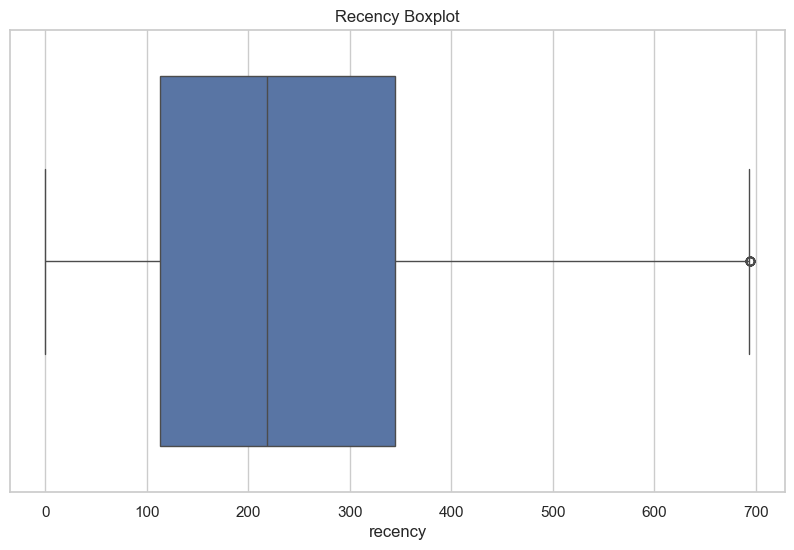

In [331]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='recency', data=RFM)
plt.title('Recency Boxplot')
plt.show()

# Frequency

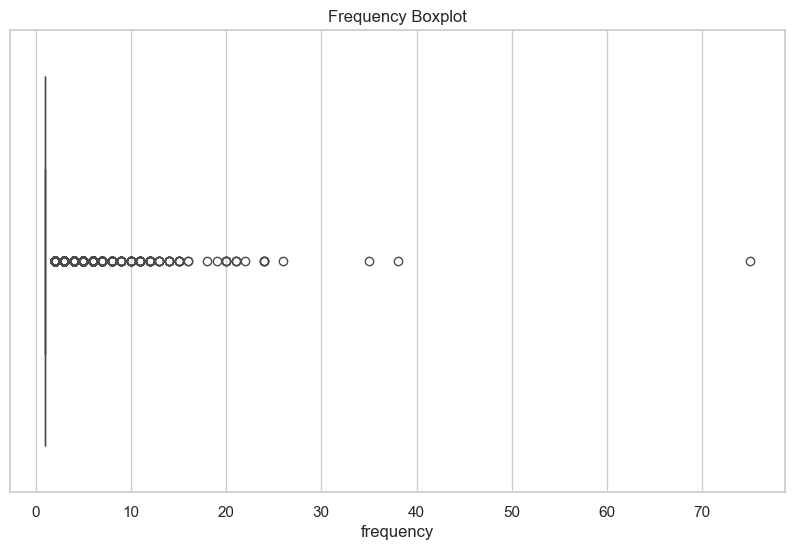

In [332]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='frequency', data=RFM)
plt.title('Frequency Boxplot')
plt.show()

In [333]:
# count each freq value desc by frequency
print(RFM['frequency'].value_counts().sort_index(ascending=False))

frequency
75        1
38        1
35        1
26        1
24        4
22        1
21        3
20        4
19        1
18        1
16        2
15        6
14        7
13        6
12       23
11       19
10       19
9        19
8        40
7        72
6       271
5       300
4       893
3      1910
2     10413
1     79317
Name: count, dtype: int64


# Monetary

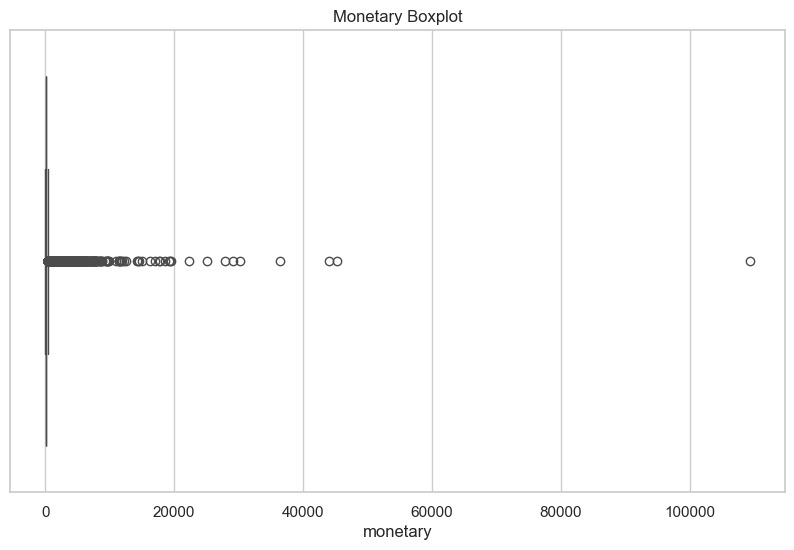

In [334]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='monetary', data=RFM)
plt.title('Monetary Boxplot')
plt.show()

# Calculate RFM Score

In [335]:
RFM['R_Score'] = pd.qcut(RFM['recency'], 3, labels=[1, 2 ,3]).astype(str)
RFM['M_Score'] = pd.qcut(RFM['monetary'], 3, labels=[1, 2 ,3]).astype(str)
RFM['F_Score'] = RFM['frequency'].apply(lambda x: '1' if x == 1 else ('2' if x == 2 else '3'))

RFM['RFM_Score'] = RFM['R_Score'] + RFM['F_Score'] + RFM['M_Score']

In [336]:
def segment(x):
    if x == '222':  # Middle value across all dimensions
        return 'Core'
    elif x in ['311', '312', '313']:  # High recency (oldest), low/mid frequency
        return 'Gone'
    elif x in ['111', '112', '113']:  # Low across board or low R&F with any monetary
        return 'Rookies'
    elif x in ['233', '333', '323']:  # High monetary with mid/high frequency and recency
        return 'Whales'
    elif x in ['221', '222', '231', '232', '322', '321']: 
        return 'Loyal'
    else:
        return 'Regular'

In [337]:
RFM['segments'] = RFM['RFM_Score'].apply(segment)
RFM['segments'].value_counts(normalize=True) * 100

segments
Regular    36.176140
Rookies    28.578775
Gone       28.086998
Whales      4.673488
Loyal       1.743183
Core        0.741415
Name: proportion, dtype: float64

In [338]:
RFM.head()

,customer_unique_id,recency,frequency,monetary,R_Score,M_Score,F_Score,RFM_Score,segments
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,1,2,1,112,Rookies
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,1,1,1,111,Rookies
2,0000f46a3911fa3c0805444483337064,536,1,86.22,3,2,1,312,Gone
3,0000f6ccb0745a6a4b88665a16c9f078,320,1,43.62,3,1,1,311,Gone
4,0004aac84e0df4da2b147fca70cf8255,287,1,196.89,2,3,1,213,Regular


In [339]:
display(RFM.describe([0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

,recency,frequency,monetary
count,93335.000000,93335.000000,93335.000000
mean,236.898752,1.232239,211.844495
std,152.545822,0.819845,642.239857
min,0.000000,1.000000,9.590000
1%,8.000000,1.000000,22.750000
5%,22.000000,1.000000,32.690000
10%,41.000000,1.000000,40.170000
25%,113.000000,1.000000,63.750000
50%,218.000000,1.000000,112.950000
75%,345.000000,1.000000,201.740000


In [340]:
segment_wise = RFM.groupby('segments').agg(RecencyMean = ('recency', 'mean'),
                                          FrequencyMean = ('frequency', 'mean'),
                                          MonetaryMean = ('monetary', 'mean'),
                                          Count = ('segments', 'count')).sort_values(by='MonetaryMean', ascending=False)

segment_wise

,RecencyMean,FrequencyMean,MonetaryMean,Count
segments,,,,
Whales,367.417698,2.969509,859.849842,4362
Regular,201.534607,1.309285,226.387115,33765
Rookies,75.009222,1.000000,154.676163,26674
Gone,417.935457,1.000000,153.300089,26215
Core,218.164740,2.000000,122.647688,692
Loyal,366.016595,2.198525,91.219385,1627


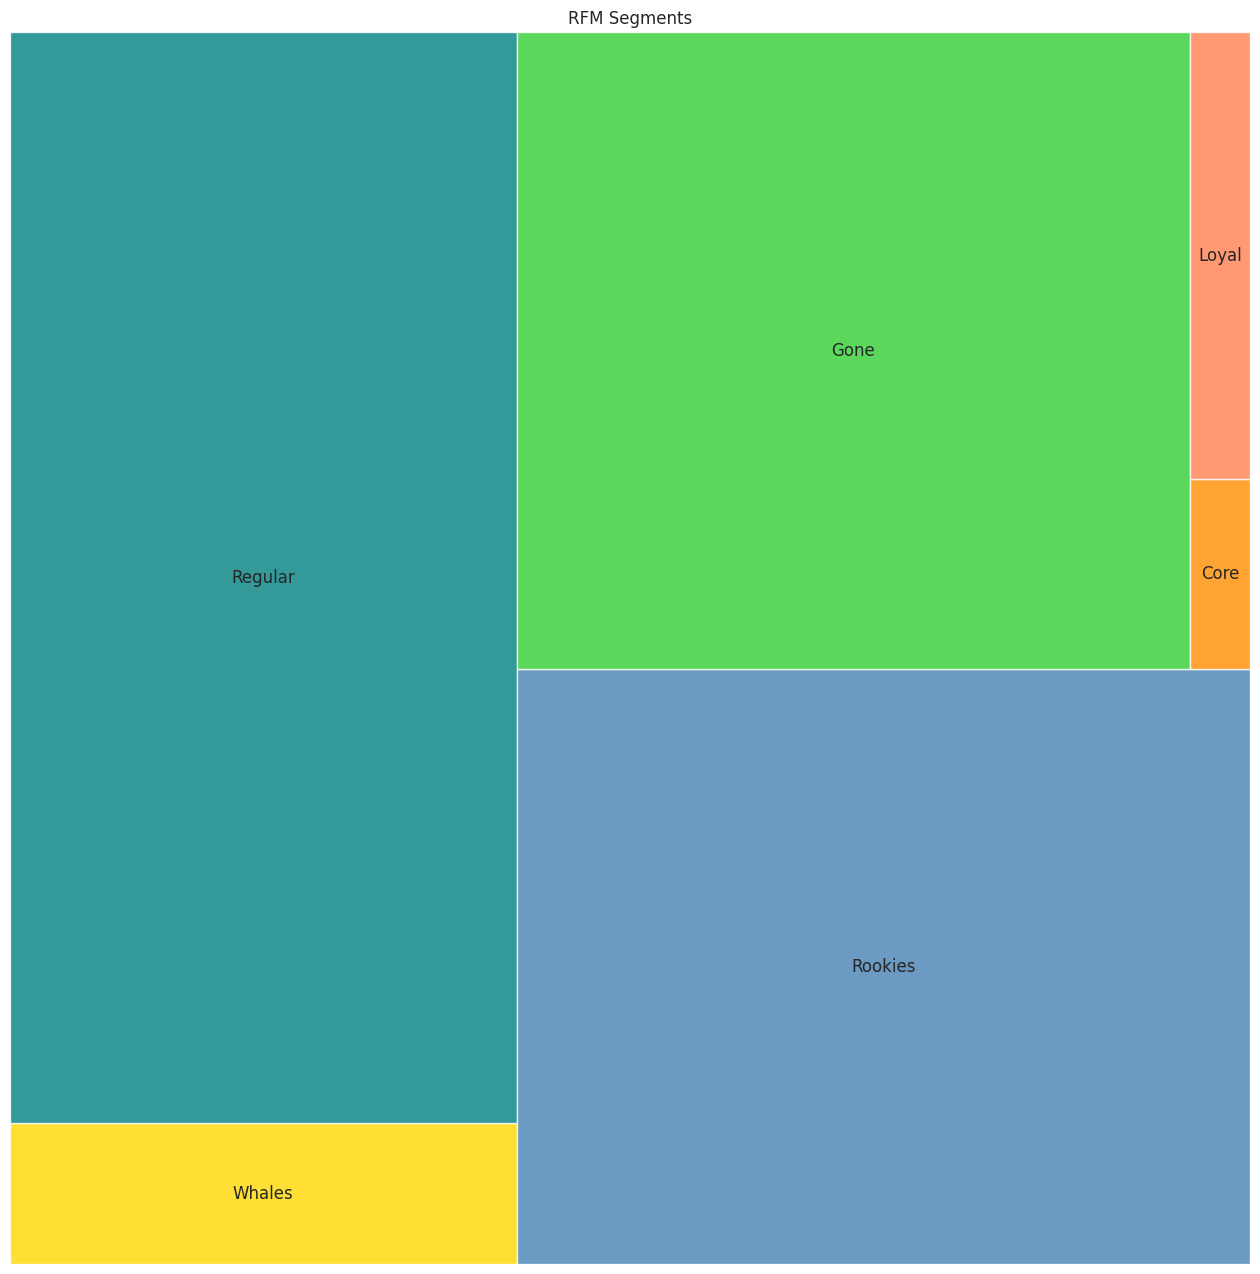

In [341]:
plt.rcParams['font.family'] = 'DejaVu Sans'

fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 16)
squarify.plot(sizes=segment_wise['Count'],
              label=segment_wise.index,
              color=['gold', 'teal', 'steelblue', 'limegreen', 'darkorange', 'coral'],
              alpha=0.8)
plt.title("RFM Segments")
plt.axis('off')
plt.show()

---

# Cross Tabulation

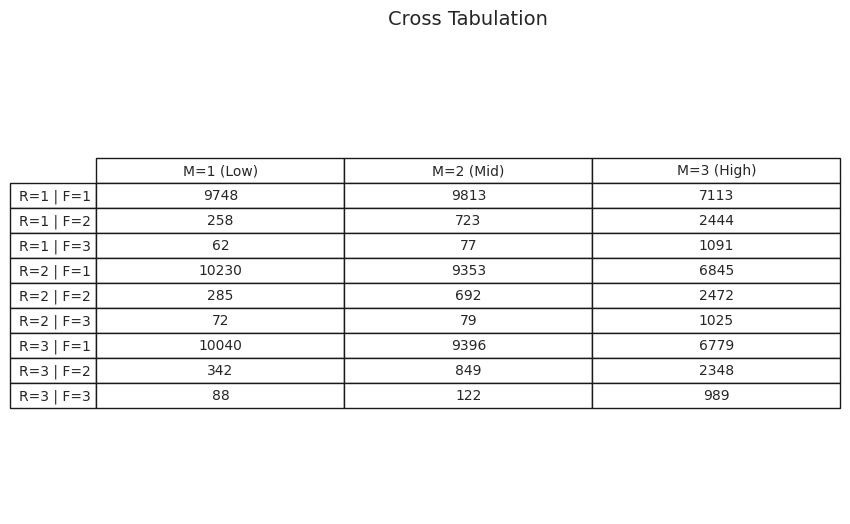

In [342]:
import pandas as pd
import matplotlib.pyplot as plt

# pake score our lord sinan
rfm_crosstab = pd.crosstab(
    index=[RFM['R_Score'], RFM['F_Score']],
    columns=RFM['M_Score'],
    rownames=['Recency Score (1 = Recent)', 'Frequency Score (1 = Low)'],
    colnames=['Monetary Score (1 = Low, 3 = High)']
)

# biar bisa columnya
rfm_flat = rfm_crosstab.reset_index()

# biar enak diliat aja
rfm_flat['Row_Label'] = rfm_flat.apply(
    lambda row: f"R={row['Recency Score (1 = Recent)']} | F={row['Frequency Score (1 = Low)']}", axis=1
)

# recency (1 = recent, 3 = oldest)
# monetary(1 = low spender, 3 = high spender)
# frequency (1 = low, 3 = highest (ya gitulah))
monetary_columns = ['1', '2', '3']
table_data = rfm_flat[monetary_columns].values
row_labels = rfm_flat['Row_Label'].tolist()
column_labels = ['M=1 (Low)', 'M=2 (Mid)', 'M=3 (High)']

# Bikin tablenya gan 
fig, ax = plt.subplots(figsize=(8, 6))
ax.axis('tight')
ax.axis('off')

table = ax.table(
    cellText=table_data,
    rowLabels=row_labels,
    colLabels=column_labels,
    loc='center',
    cellLoc='center'
)

table.scale(1.2, 1.5)
table.auto_set_font_size(False)
table.set_fontsize(10)

# Add title
plt.title("Cross Tabulation", fontsize=14, pad=20)

# Show the table
plt.show()


---

# RFMD

In [343]:
customer_state_dict = customers_dataset.set_index('customer_unique_id')['customer_state'].to_dict()

RFM['State'] = RFM['customer_unique_id'].map(customer_state_dict)

RFMD_heatmap = RFM.copy()
RFMD_Raw = RFM.copy()
display(RFMD_heatmap.head())

,customer_unique_id,recency,frequency,monetary,R_Score,M_Score,F_Score,RFM_Score,segments,State
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,1,2,1,112,Rookies,SP
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,1,1,1,111,Rookies,SP
2,0000f46a3911fa3c0805444483337064,536,1,86.22,3,2,1,312,Gone,SC
3,0000f6ccb0745a6a4b88665a16c9f078,320,1,43.62,3,1,1,311,Gone,PA
4,0004aac84e0df4da2b147fca70cf8255,287,1,196.89,2,3,1,213,Regular,SP


In [344]:
# dropping unnecessary columns
RFMD_heatmap.drop(['segments', 'recency', 'frequency', 'M_Score', 'RFM_Score'], axis=1, inplace=True)

# re-arrange columns
RFMD_heatmap = RFMD_heatmap[['customer_unique_id', 'R_Score', 'F_Score', 'monetary', 'State']] 

# rename columns
RFMD_heatmap.columns = ['Customer Unique ID', 'Recency', 'Frequency', 'Monetary', 'State']

print(RFMD_heatmap.head())
print(RFMD_heatmap.describe())
print(RFMD_heatmap.info())

                 Customer Unique ID Recency Frequency  Monetary State
0  0000366f3b9a7992bf8c76cfdf3221e2       1         1    141.90    SP
1  0000b849f77a49e4a4ce2b2a4ca5be3f       1         1     27.19    SP
2  0000f46a3911fa3c0805444483337064       3         1     86.22    SC
3  0000f6ccb0745a6a4b88665a16c9f078       3         1     43.62    PA
4  0004aac84e0df4da2b147fca70cf8255       2         1    196.89    SP
            Monetary
count   93335.000000
mean      211.844495
std       642.239857
min         9.590000
25%        63.750000
50%       112.950000
75%       201.740000
max    109312.640000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93335 entries, 0 to 93334
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Unique ID  93335 non-null  object 
 1   Recency             93335 non-null  object 
 2   Frequency           93335 non-null  object 
 3   Monetary            93335 non-nul

In [345]:
RFMD_heatmap.describe()

,Monetary
count,93335.000000
mean,211.844495
std,642.239857
min,9.590000
25%,63.750000
50%,112.950000
75%,201.740000
max,109312.640000


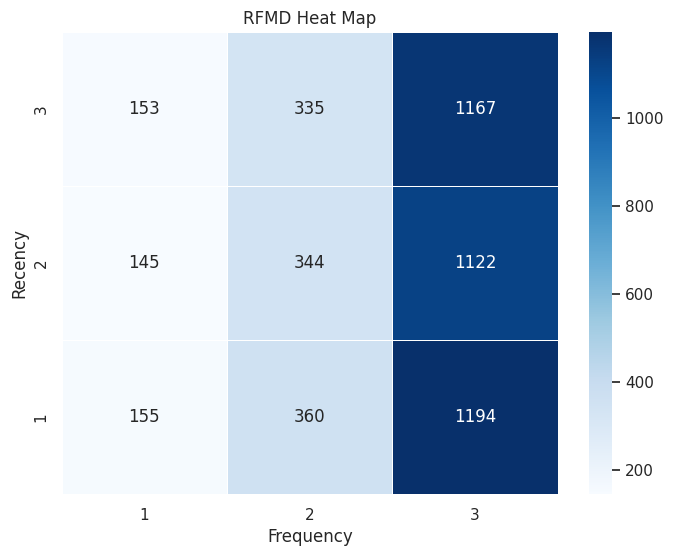

In [346]:
# heat map
rfmd_pivot = RFMD_heatmap.pivot_table(index='Recency', columns='Frequency', values='Monetary', aggfunc='mean').sort_index(ascending=False)

plt.figure(figsize=(8, 6))
sns.heatmap(rfmd_pivot, cmap="Blues", annot=True, fmt='.0f', linewidths=.5)
plt.title("RFMD Heat Map")
plt.xlabel("Frequency")
plt.ylabel("Recency")
plt.show()

# Change State to it's abbreviation

In [347]:
# Create a dictionary to map state abbreviations to cardinal directions
state_direction = {
    'AC': 'North',
    'AP': 'North',
    'AM': 'North',
    'PA': 'North',
    'RO': 'North',
    'TO': 'North',
    'RR': 'North',
    'AL': 'Northeast',
    'BA': 'Northeast',
    'CE': 'Northeast',
    'MA': 'Northeast',
    'PE': 'Northeast',
    'PI': 'Northeast',
    'SE': 'Northeast',
    'PB': 'Northeast',
    'RN': 'Northeast',
    'DF': 'Mid-West',
    'GO': 'Mid-West',
    'MT': 'Mid-West',
    'MS': 'Mid-West',
    'MG': 'Southeast',
    'ES': 'Southeast',
    'RJ': 'Southeast',
    'SP': 'Southeast',
    'PR': 'South',
    'RS': 'South',
    'SC': 'South'
}

# Map the states to their corresponding cardinal directions
RFMD_heatmap['State'] = RFMD_heatmap['State'].map(state_direction)
RFMD_Raw['State'] = RFMD_Raw['State'].map(state_direction)

In [348]:
RFMD_heatmap.head()

,Customer Unique ID,Recency,Frequency,Monetary,State
0,0000366f3b9a7992bf8c76cfdf3221e2,1,1,141.90,Southeast
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,1,27.19,Southeast
2,0000f46a3911fa3c0805444483337064,3,1,86.22,South
3,0000f6ccb0745a6a4b88665a16c9f078,3,1,43.62,North
4,0004aac84e0df4da2b147fca70cf8255,2,1,196.89,Southeast


---

# SAMTING

In [349]:
# drop unnecessary columns
RFMD_Raw.drop(['R_Score', 'M_Score', 'F_Score', 'RFM_Score', 'segments'], axis=1, inplace=True)

RFMD_Raw.head()

,customer_unique_id,recency,frequency,monetary,State
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,Southeast
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,Southeast
2,0000f46a3911fa3c0805444483337064,536,1,86.22,South
3,0000f6ccb0745a6a4b88665a16c9f078,320,1,43.62,North
4,0004aac84e0df4da2b147fca70cf8255,287,1,196.89,Southeast


In [350]:
# describe %1 %5 %10 %25 %50 %75 %90 %95 %99
RFMD_Raw.describe([0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).T

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
recency,93335.0,236.898752,152.545822,0.00,8.00,22.00,41.00,113.00,218.00,345.00,464.600,519.000,574.0000,694.00
frequency,93335.0,1.232239,0.819845,1.00,1.00,1.00,1.00,1.00,1.00,1.00,2.000,2.000,4.0000,75.00
monetary,93335.0,211.844495,642.239857,9.59,22.75,32.69,40.17,63.75,112.95,201.74,402.136,658.947,1672.4694,109312.64


In [351]:
def iqr_outliers(df):
    # Create a copy of the DataFrame to avoid modifying the original
    df_clean = df.copy()
    
    # Numeric columns to analyze
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    
    # Outlier detection results
    outlier_results = {}
    
    # Descriptive statistics with multiple percentiles
    desc_stats = df.describe([0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).T
    
    # Outlier detection for each numeric column
    for column in numeric_columns:
        # Calculate IQR
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        # Calculate bounds
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        
        # Find outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
        
        # Store results
        outlier_results[column] = {
            'Q1': Q1,
            'Q3': Q3,
            'IQR': IQR,
            'Lower Bound': lower_bound,
            'Upper Bound': upper_bound,
            'Outliers Count': len(outliers),
            'Outlier Percentage': (len(outliers) / len(df)) * 100
        }
        
        # Remove outliers from the clean DataFrame
        df_clean = df_clean[(df_clean[column] >= lower_bound) & (df_clean[column] <= upper_bound)]
        
    return desc_stats, outlier_results, df_clean

In [352]:
def z_score_outliers(df):
    # Create a copy of the DataFrame to avoid modifying the original
    df_clean = df.copy()
    
    # Numeric columns to analyze
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    
    # Outlier detection results
    outlier_results = {}
    
    # Descriptive statistics with multiple percentiles
    desc_stats = df.describe([0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).T
    
    # Outlier detection for each numeric column
    for column in numeric_columns:
        # Calculate Z-scores
        z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())
        
        # Find outliers using DataFrame's boolean indexing
        outlier_mask = z_scores > 3
        outliers = df.loc[outlier_mask, column]
        
        # Store results
        outlier_results[column] = {
            'Outliers Count': len(outliers),
            'Outlier Percentage': (len(outliers) / len(df)) * 100
        }
        
        # Remove outliers from the clean DataFrame
        df_clean = df_clean.loc[~outlier_mask]
    
    return desc_stats, outlier_results, df_clean

In [353]:
def print_outlier_analysis(df):
    # Get descriptive statistics and outlier information
    # desc_stats, outlier_results, df_clean = iqr_outliers(df)
    desc_stats, outlier_results, df_clean = z_score_outliers(df)
    
    print("Descriptive Statistics:")
    print(desc_stats)
    print("\n--- Outlier Analysis ---")
    
    for column, results in outlier_results.items():
        print(f"\nColumn: {column}")
        print(f"Outliers Count: {results['Outliers Count']}")
        print(f"Outlier Percentage: {results['Outlier Percentage']:.2f}%")

    print(f"\nOriginal DataFrame size: {len(df)}")
    print(f"Cleaned DataFrame size: {len(df_clean)}")
    print(f"Total Rows Removed: {len(df) - len(df_clean)}")
    return df_clean

In [354]:
df_clean = print_outlier_analysis(RFMD_Raw)

Descriptive Statistics:
             count        mean         std   min     1%     5%    10%     25%  \
recency    93335.0  236.898752  152.545822  0.00   8.00  22.00  41.00  113.00   
frequency  93335.0    1.232239    0.819845  1.00   1.00   1.00   1.00    1.00   
monetary   93335.0  211.844495  642.239857  9.59  22.75  32.69  40.17   63.75   

              50%     75%      90%      95%        99%        max  
recency    218.00  345.00  464.600  519.000   574.0000     694.00  
frequency    1.00    1.00    2.000    2.000     4.0000      75.00  
monetary   112.95  201.74  402.136  658.947  1672.4694  109312.64  

--- Outlier Analysis ---

Column: recency
Outliers Count: 0
Outlier Percentage: 0.00%

Column: frequency
Outliers Count: 1695
Outlier Percentage: 1.82%

Column: monetary
Outliers Count: 571
Outlier Percentage: 0.61%

Original DataFrame size: 93335
Cleaned DataFrame size: 91393
Total Rows Removed: 1942


In [355]:
# describe %1 %5 %10 %25 %50 %75 %90 %95 %99
df_clean.describe([0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).T

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
recency,91393.0,236.853424,152.456559,0.00,8.0,22.000,41.0,113.0,218.00,345.00,464.00,518.00,574.0000,694.00
frequency,91393.0,1.153382,0.412486,1.00,1.0,1.000,1.0,1.0,1.00,1.00,2.00,2.00,3.0000,3.00
monetary,91393.0,175.838634,213.591769,9.59,22.7,32.548,40.0,63.1,110.88,194.64,365.32,565.25,1148.0416,2133.69


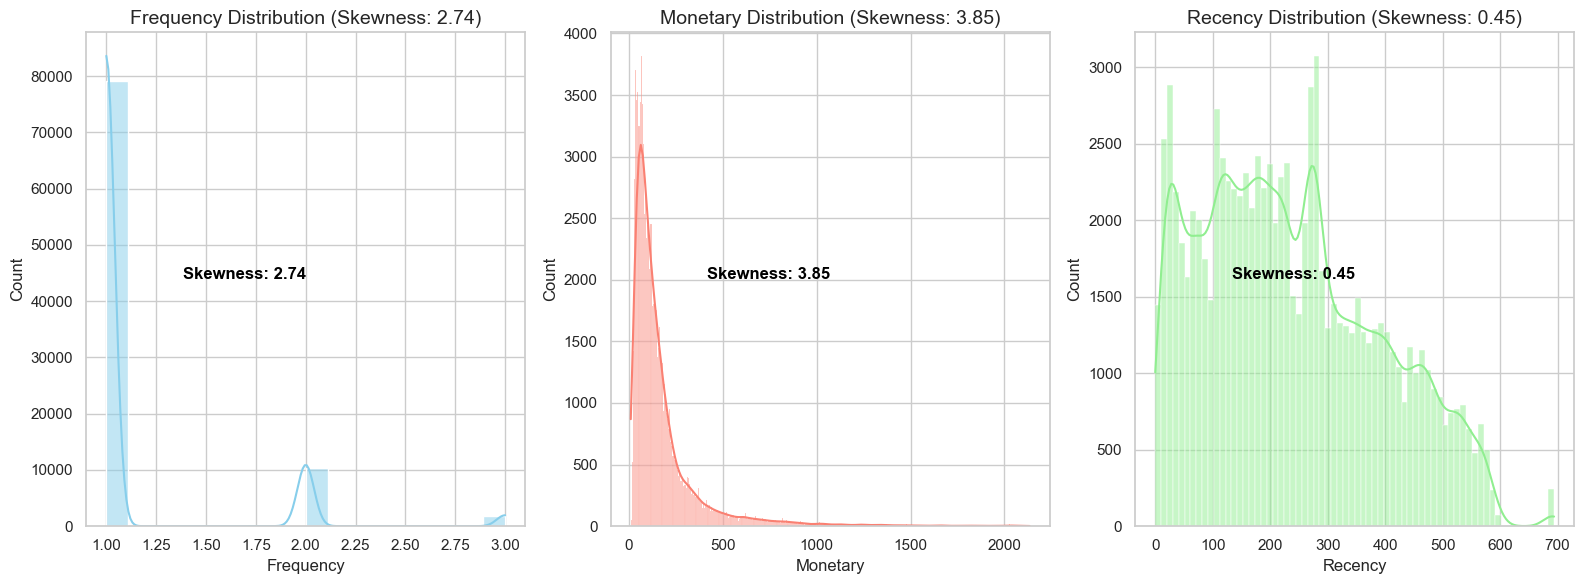

In [356]:
frequency_skew = df_clean['frequency'].skew()
monetary_skew = df_clean['monetary'].skew()
recency_skew = df_clean['recency'].skew()

sns.set_theme(style='whitegrid')

fig, axes = plt.subplots(1, 3, figsize=(16, 6))

sns.histplot(df_clean['frequency'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title(f'Frequency Distribution (Skewness: {frequency_skew:.2f})', fontsize=14)
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Count')
axes[0].text(0.5, 0.5, f'Skewness: {frequency_skew:.2f}', transform=axes[0].transAxes, horizontalalignment='right', color='black', weight='bold', fontsize=12)

sns.histplot(df_clean['monetary'], kde=True, ax=axes[1], color='salmon')
axes[1].set_title(f'Monetary Distribution (Skewness: {monetary_skew:.2f})', fontsize=14)
axes[1].set_xlabel('Monetary')
axes[1].set_ylabel('Count')
axes[1].text(0.5, 0.5, f'Skewness: {monetary_skew:.2f}', transform=axes[1].transAxes, horizontalalignment='right', color='black', weight='bold', fontsize=12)

sns.histplot(df_clean['recency'], kde=True, ax=axes[2], color='lightgreen')
axes[2].set_title(f'Recency Distribution (Skewness: {recency_skew:.2f})', fontsize=14)
axes[2].set_xlabel('Recency')
axes[2].set_ylabel('Count')
axes[2].text(0.5, 0.5, f'Skewness: {recency_skew:.2f}', transform=axes[2].transAxes, horizontalalignment='right', color='black', weight='bold', fontsize=12)

plt.tight_layout()
plt.show()

In [357]:
# describe RMFD for 1% 5% 10% 25% 50% 75% 90% 95% 99%
RMFD_features = df_clean[['recency', 'frequency', 'monetary']].copy()
pt = PowerTransformer(method='box-cox')
pt_yj = PowerTransformer(method='yeo-johnson')

# do log transformation on frequency because the data is skewed beyond comprehension
# log1p
RMFD_features['frequency_log1p'] = np.log1p(RMFD_features['frequency'])
frequency_skew_log1p = RMFD_features['frequency_log1p'].skew()

# log 10
RMFD_features['frequency_log10'] = np.log10(RMFD_features['frequency'])
frequency_skew_log10 = RMFD_features['frequency_log10'].skew()

# boxcox
RMFD_features['frequency_boxcox'] = pt.fit_transform(RMFD_features[['frequency']].values.reshape(-1, 1)).flatten()
frequency_skew_boxcox = RMFD_features['frequency_boxcox'].skew()

# yeo-johnson
RMFD_features['frequency_yeoh'] = pt_yj.fit_transform(RMFD_features[['frequency']].values.reshape(-1, 1)).flatten()
frequency_skew_yeoh = RMFD_features['frequency_yeoh'].skew()

# square root
RMFD_features['frequency_sqrt'] = np.sqrt(RMFD_features['frequency'])
frequency_skew_sqrt = RMFD_features['frequency_sqrt'].skew()

# cube root 
RMFD_features['frequency_cube'] = np.cbrt(RMFD_features['frequency'])
frequency_skew_cube = RMFD_features['frequency_cube'].skew()

# log 
# RMFD_features['monetary_log'] = np.log1p(RMFD_features['monetary'])

# box cox transformation
RMFD_features['monetary_log'] = pt.fit_transform(RMFD_features[['monetary']].values.reshape(-1, 1)).flatten()

# don't need to transform recency, because it's not skewed
# RMFD_features['recency_log'] = np.log1p(RMFD_features['recency'])
print("POST-TRANSFORMATION SKEW: \n", RMFD_features.skew())

POST-TRANSFORMATION SKEW: 
 recency             0.446314
frequency           2.740733
monetary            3.852180
frequency_log1p     2.474611
frequency_log10     2.378726
frequency_boxcox    2.158531
frequency_yeoh      2.158531
frequency_sqrt      2.523383
frequency_cube      2.468034
monetary_log        0.018082
dtype: float64


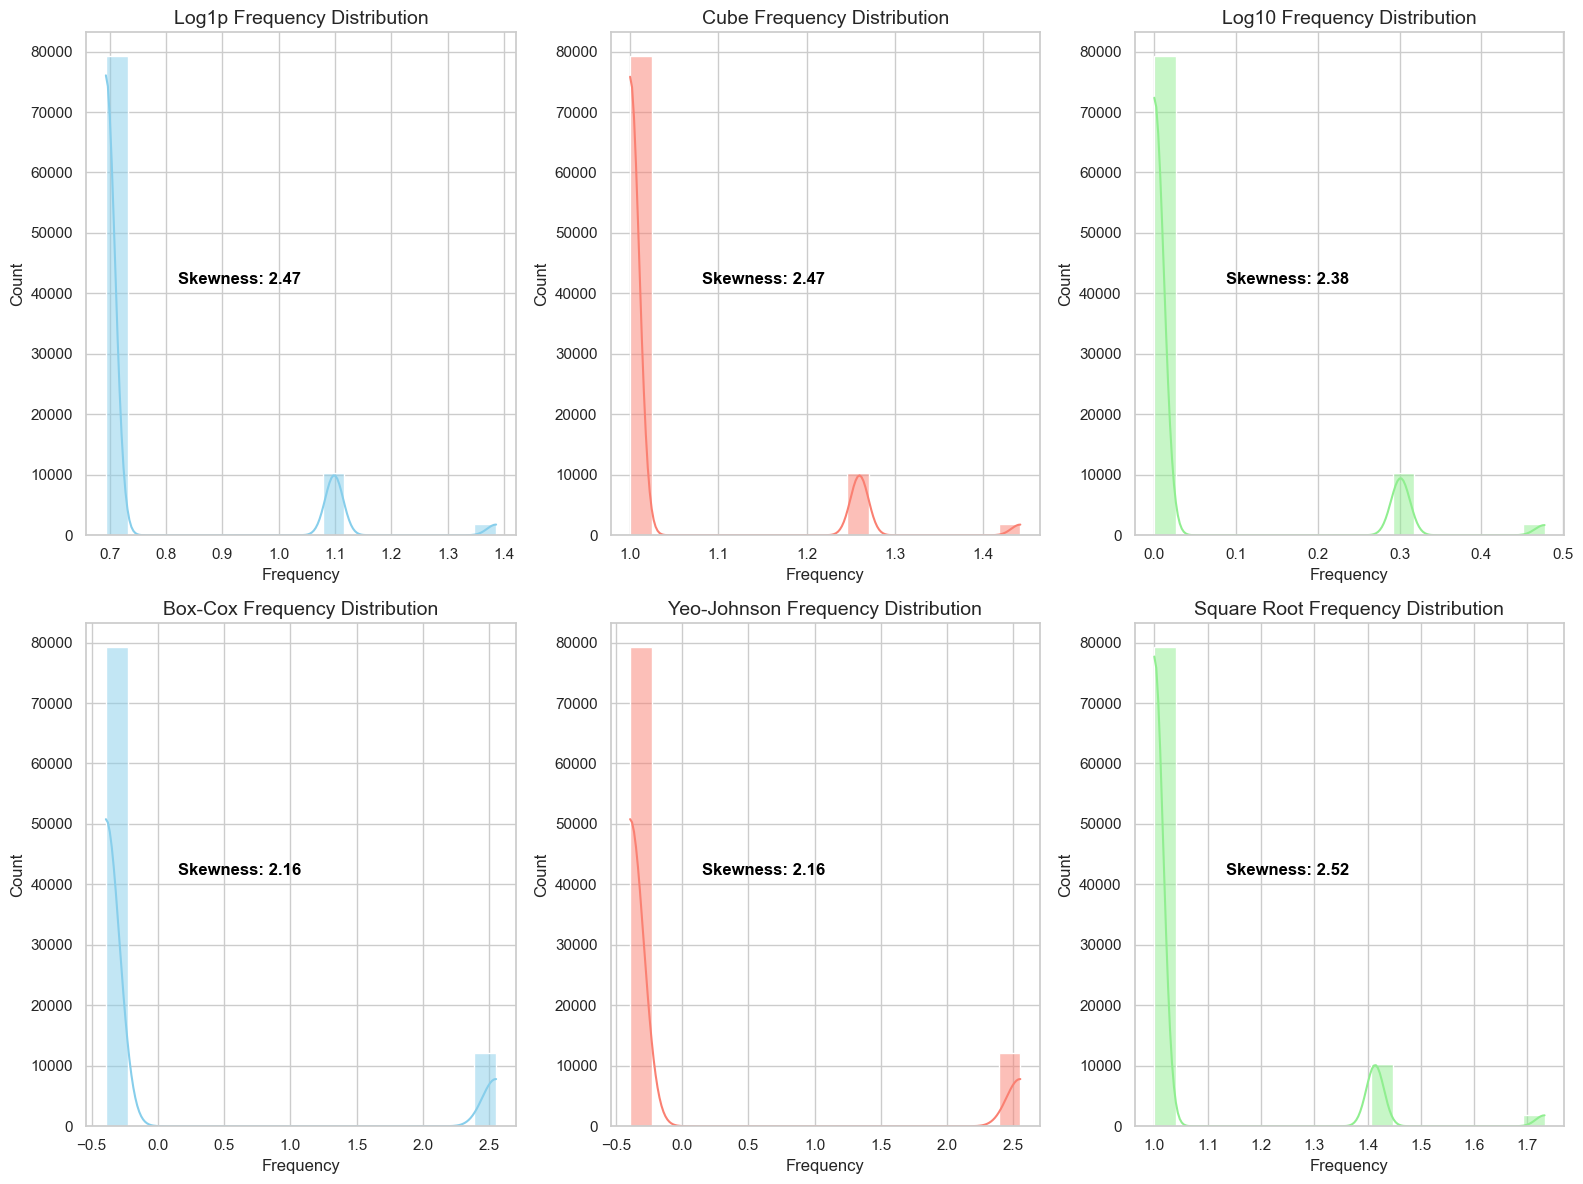

In [358]:
# plot all frequency transformation
# plot for 7 transformation
fig, axes = plt.subplots(2, 3, figsize=(16, 12))

# log1p
sns.histplot(RMFD_features['frequency_log1p'], kde=True, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Log1p Frequency Distribution', fontsize=14)
axes[0, 0].set_xlabel('Frequency')
axes[0, 0].set_ylabel('Count')
axes[0, 0].text(0.5, 0.5, f'Skewness: {frequency_skew_log1p:.2f}', transform=axes[0, 0].transAxes, horizontalalignment='right', color='black', weight='bold', fontsize=12)

# cube root
sns.histplot(RMFD_features['frequency_cube'], kde=True, ax=axes[0, 1], color='salmon')
axes[0, 1].set_title('Cube Frequency Distribution', fontsize=14)
axes[0, 1].set_xlabel('Frequency')
axes[0, 1].set_ylabel('Count')
axes[0, 1].text(0.5, 0.5, f'Skewness: {frequency_skew_cube:.2f}', transform=axes[0, 1].transAxes, horizontalalignment='right', color='black', weight='bold', fontsize=12)

# log10
sns.histplot(RMFD_features['frequency_log10'], kde=True, ax=axes[0, 2], color='lightgreen')
axes[0, 2].set_title('Log10 Frequency Distribution', fontsize=14)
axes[0, 2].set_xlabel('Frequency')
axes[0, 2].set_ylabel('Count')
axes[0, 2].text(0.5, 0.5, f'Skewness: {frequency_skew_log10:.2f}', transform=axes[0, 2].transAxes, horizontalalignment='right', color='black', weight='bold', fontsize=12)

# boxcox
sns.histplot(RMFD_features['frequency_boxcox'], kde=True, ax=axes[1, 0], color='skyblue')
axes[1, 0].set_title('Box-Cox Frequency Distribution', fontsize=14)
axes[1, 0].set_xlabel('Frequency')
axes[1, 0].set_ylabel('Count')
axes[1, 0].text(0.5, 0.5, f'Skewness: {frequency_skew_boxcox:.2f}', transform=axes[1, 0].transAxes, horizontalalignment='right', color='black', weight='bold', fontsize=12)

# yeo-johnson
sns.histplot(RMFD_features['frequency_yeoh'], kde=True, ax=axes[1, 1], color='salmon')
axes[1, 1].set_title('Yeo-Johnson Frequency Distribution', fontsize=14)
axes[1, 1].set_xlabel('Frequency')
axes[1, 1].set_ylabel('Count')
axes[1, 1].text(0.5, 0.5, f'Skewness: {frequency_skew_yeoh:.2f}', transform=axes[1, 1].transAxes, horizontalalignment='right', color='black', weight='bold', fontsize=12)

# square root
sns.histplot(RMFD_features['frequency_sqrt'], kde=True, ax=axes[1, 2], color='lightgreen')
axes[1, 2].set_title('Square Root Frequency Distribution', fontsize=14)
axes[1, 2].set_xlabel('Frequency')
axes[1, 2].set_ylabel('Count')
axes[1, 2].text(0.5, 0.5, f'Skewness: {frequency_skew_sqrt:.2f}', transform=axes[1, 2].transAxes, horizontalalignment='right', color='black', weight='bold', fontsize=12)

plt.tight_layout()
plt.show()

In [359]:
# based of the skewness, the best transformation is log10
RMFD_features['frequency_log'] = RMFD_features['frequency_boxcox']

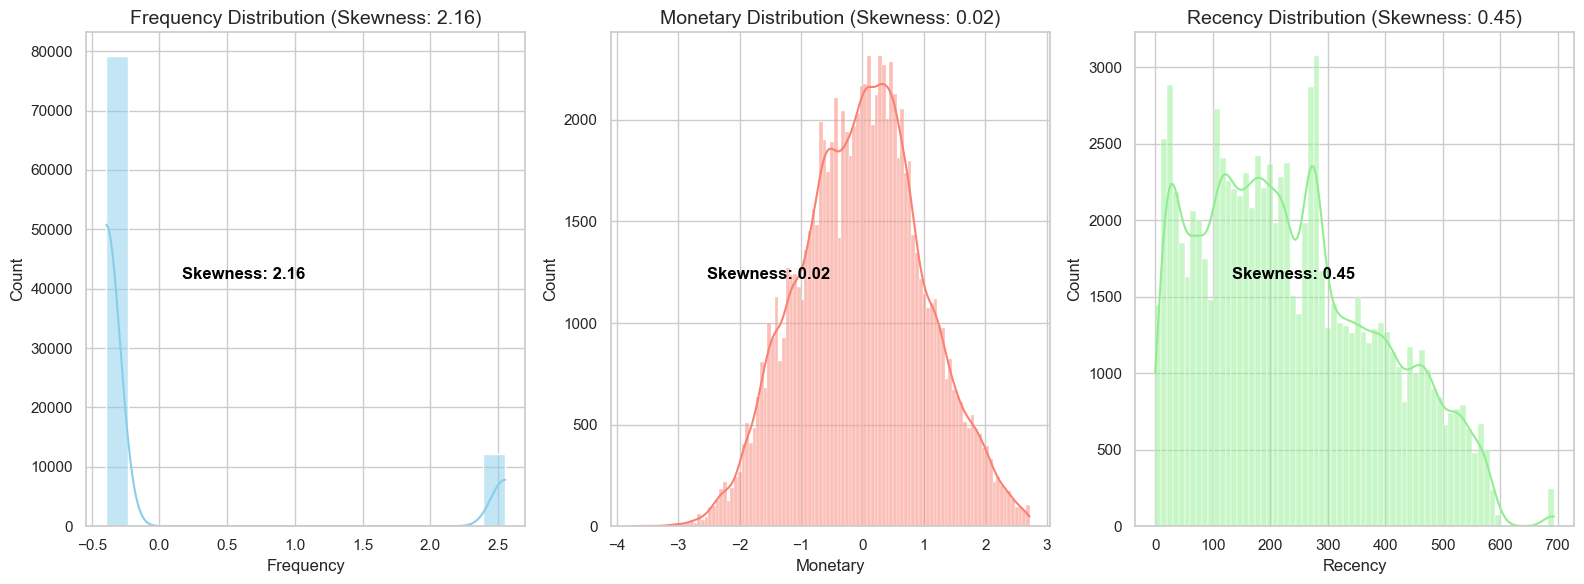

In [360]:
frequency_skew = RMFD_features['frequency_log'].skew()
monetary_skew = RMFD_features['monetary_log'].skew()
recency_skew = RMFD_features['recency'].skew()

sns.set_theme(style='whitegrid')

fig, axes = plt.subplots(1, 3, figsize=(16, 6))

sns.histplot(RMFD_features['frequency_log'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title(f'Frequency Distribution (Skewness: {frequency_skew:.2f})', fontsize=14)
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Count')
axes[0].text(0.5, 0.5, f'Skewness: {frequency_skew:.2f}', transform=axes[0].transAxes, horizontalalignment='right', color='black', weight='bold', fontsize=12)

sns.histplot(RMFD_features['monetary_log'], kde=True, ax=axes[1], color='salmon')
axes[1].set_title(f'Monetary Distribution (Skewness: {monetary_skew:.2f})', fontsize=14)
axes[1].set_xlabel('Monetary')
axes[1].set_ylabel('Count')
axes[1].text(0.5, 0.5, f'Skewness: {monetary_skew:.2f}', transform=axes[1].transAxes, horizontalalignment='right', color='black', weight='bold', fontsize=12)

sns.histplot(RMFD_features['recency'], kde=True, ax=axes[2], color='lightgreen')
axes[2].set_title(f'Recency Distribution (Skewness: {recency_skew:.2f})', fontsize=14)
axes[2].set_xlabel('Recency')
axes[2].set_ylabel('Count')
axes[2].text(0.5, 0.5, f'Skewness: {recency_skew:.2f}', transform=axes[2].transAxes, horizontalalignment='right', color='black', weight='bold', fontsize=12)

plt.tight_layout()
plt.show()

In [361]:
# describe %1 %5 %10 %25 %50 %75 %90 %95 %99
RMFD_features.describe([0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).T

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
recency,91393.0,2.368534e+02,152.456559,0.000000,8.000000,22.000000,41.000000,113.000000,218.000000,345.000000,464.000000,518.000000,574.000000,694.000000
frequency,91393.0,1.153382e+00,0.412486,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,3.000000,3.000000
monetary,91393.0,1.758386e+02,213.591769,9.590000,22.700000,32.548000,40.000000,63.100000,110.880000,194.640000,365.320000,565.250000,1148.041600,2133.690000
frequency_log1p,91393.0,7.529655e-01,0.157140,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,1.098612,1.098612,1.386294,1.386294
frequency_log10,91393.0,4.365571e-02,0.113703,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.301030,0.301030,0.477121,0.477121
frequency_boxcox,91393.0,-3.560760e-17,1.000005,-0.392070,-0.392070,-0.392070,-0.392070,-0.392070,-0.392070,-0.392070,2.550102,2.550102,2.553157,2.553157
frequency_yeoh,91393.0,-6.426045e-11,1.000005,-0.392070,-0.392070,-0.392070,-0.392070,-0.392070,-0.392070,-0.392070,2.550038,2.550038,2.553520,2.553520
frequency_sqrt,91393.0,1.061591e+00,0.162498,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.414214,1.414214,1.732051,1.732051
frequency_cube,91393.0,1.038304e+00,0.100565,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.259921,1.259921,1.442250,1.442250
monetary_log,91393.0,1.017849e-15,1.000005,-3.770397,-2.219329,-1.645390,-1.335044,-0.692353,0.026011,0.667148,1.304477,1.701773,2.277638,2.719009


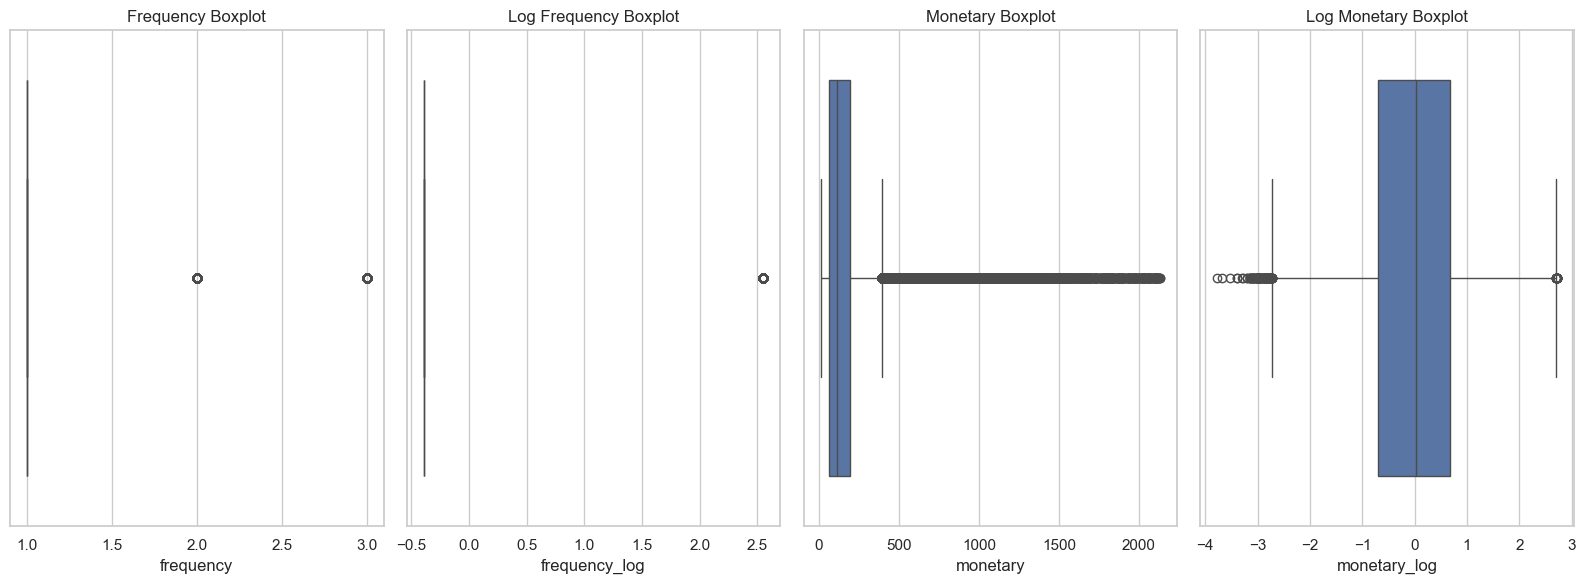

In [362]:
# plot frequency before and after log transformation
fig, axes = plt.subplots(1, 4, figsize=(16, 6))

sns.boxplot(x='frequency', data=RMFD_features, ax=axes[0])
axes[0].set_title('Frequency Boxplot')

sns.boxplot(x='frequency_log', data=RMFD_features, ax=axes[1])
axes[1].set_title('Log Frequency Boxplot')

sns.boxplot(x='monetary', data=RMFD_features, ax=axes[2])
axes[2].set_title('Monetary Boxplot')

sns.boxplot(x='monetary_log', data=RMFD_features, ax=axes[3])
axes[3].set_title('Log Monetary Boxplot')

plt.tight_layout()
plt.show()

In [363]:
# do label encoding for state
state_encoder = LabelEncoder()
state_encoded = state_encoder.fit_transform(RFMD_Raw['State'])

state_df = pd.DataFrame(state_encoded, columns=['State'])
# print each state and their corresponding encoded value
state_mapping = dict(zip(state_encoder.classes_, state_encoder.transform(state_encoder.classes_)))
display(f"State mapping: {state_mapping}")

"State mapping: {'Mid-West': np.int64(0), 'North': np.int64(1), 'Northeast': np.int64(2), 'South': np.int64(3), 'Southeast': np.int64(4)}"

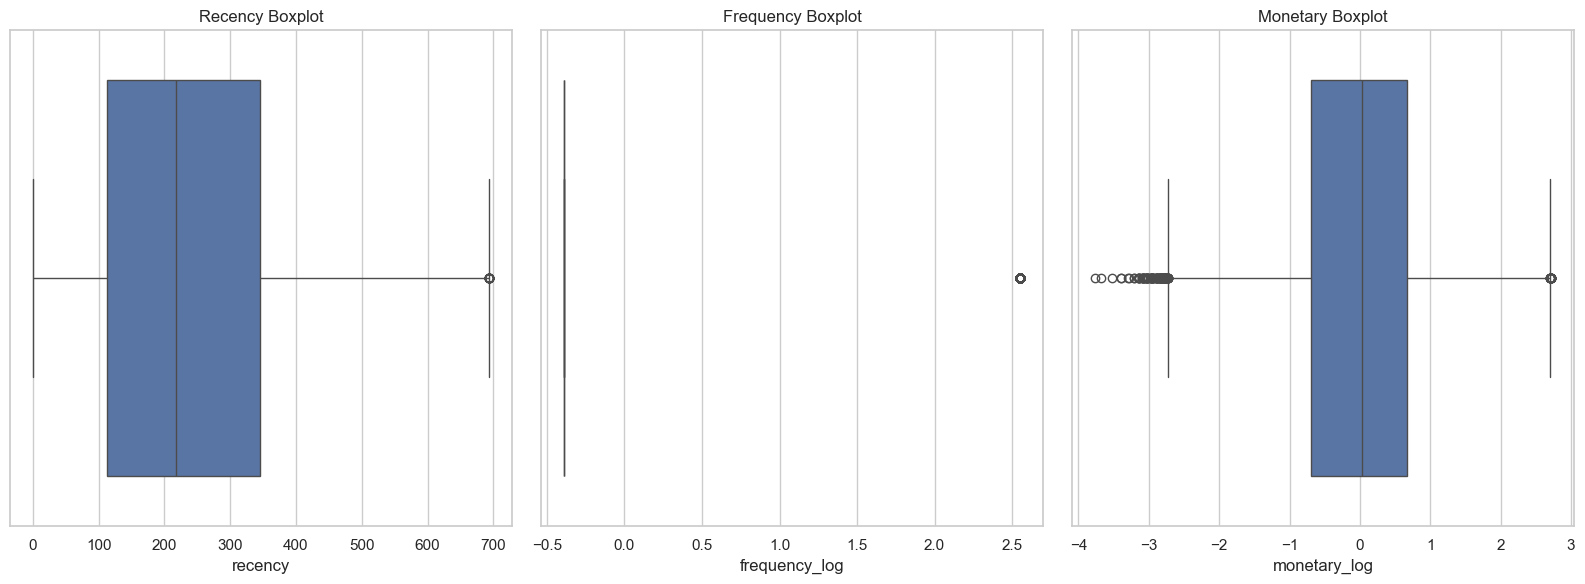

In [364]:
# plot before scaling
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

sns.boxplot(x='recency', data=RMFD_features, ax=axes[0])
axes[0].set_title('Recency Boxplot')

sns.boxplot(x='frequency_log', data=RMFD_features, ax=axes[1])
axes[1].set_title('Frequency Boxplot')

sns.boxplot(x='monetary_log', data=RMFD_features, ax=axes[2])
axes[2].set_title('Monetary Boxplot')

plt.tight_layout()
plt.show()

In [365]:
# standardize RMFD features
# scaler = RobustScaler()
# RMFD_scaled = scaler.fit_transform(RMFD_features[['recency', 'frequency_log', 'monetary_log']])

scaler = StandardScaler()
RMFD_scaled = scaler.fit_transform(RMFD_features[['recency', 'frequency_log', 'monetary_log']])

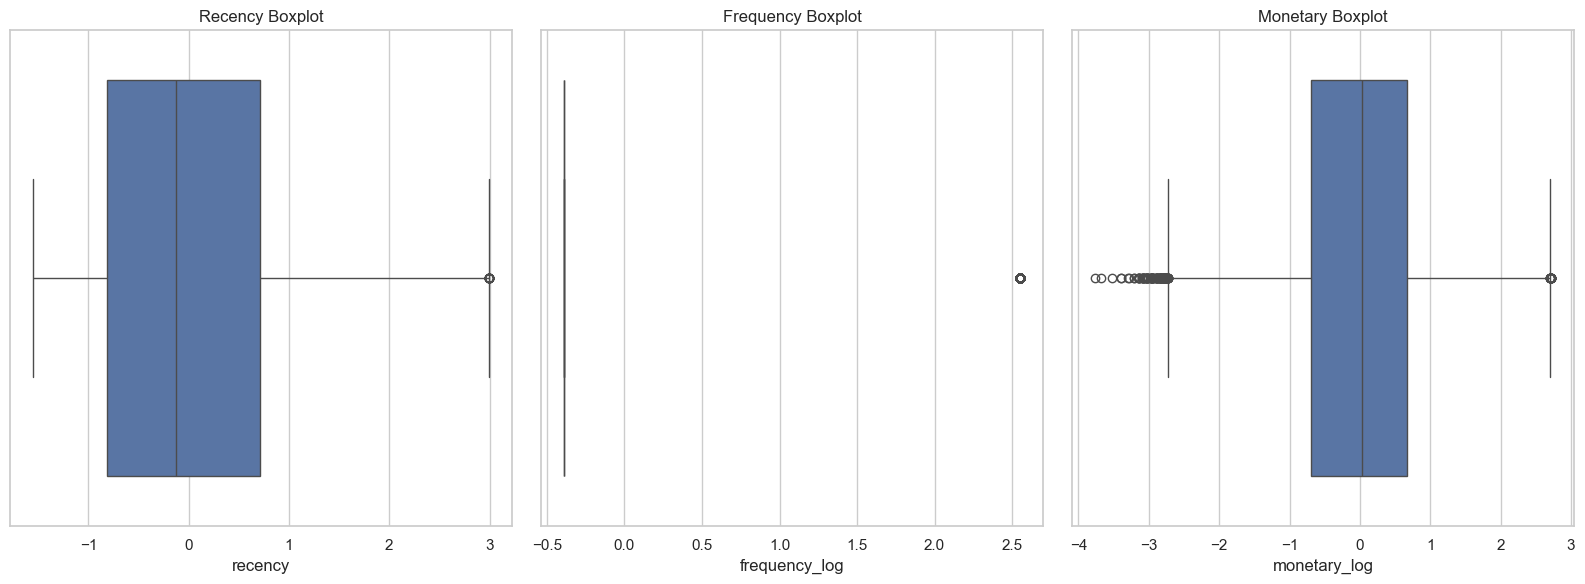

In [366]:
# plot after scaling
RMFD_scaled = pd.DataFrame(RMFD_scaled, columns=['recency', 'frequency_log', 'monetary_log'])

fig, axes = plt.subplots(1, 3, figsize=(16, 6))

sns.boxplot(x='recency', data=RMFD_scaled, ax=axes[0])
axes[0].set_title('Recency Boxplot')

sns.boxplot(x='frequency_log', data=RMFD_scaled, ax=axes[1])
axes[1].set_title('Frequency Boxplot')

sns.boxplot(x='monetary_log', data=RMFD_scaled, ax=axes[2])
axes[2].set_title('Monetary Boxplot')

plt.tight_layout()
plt.show()

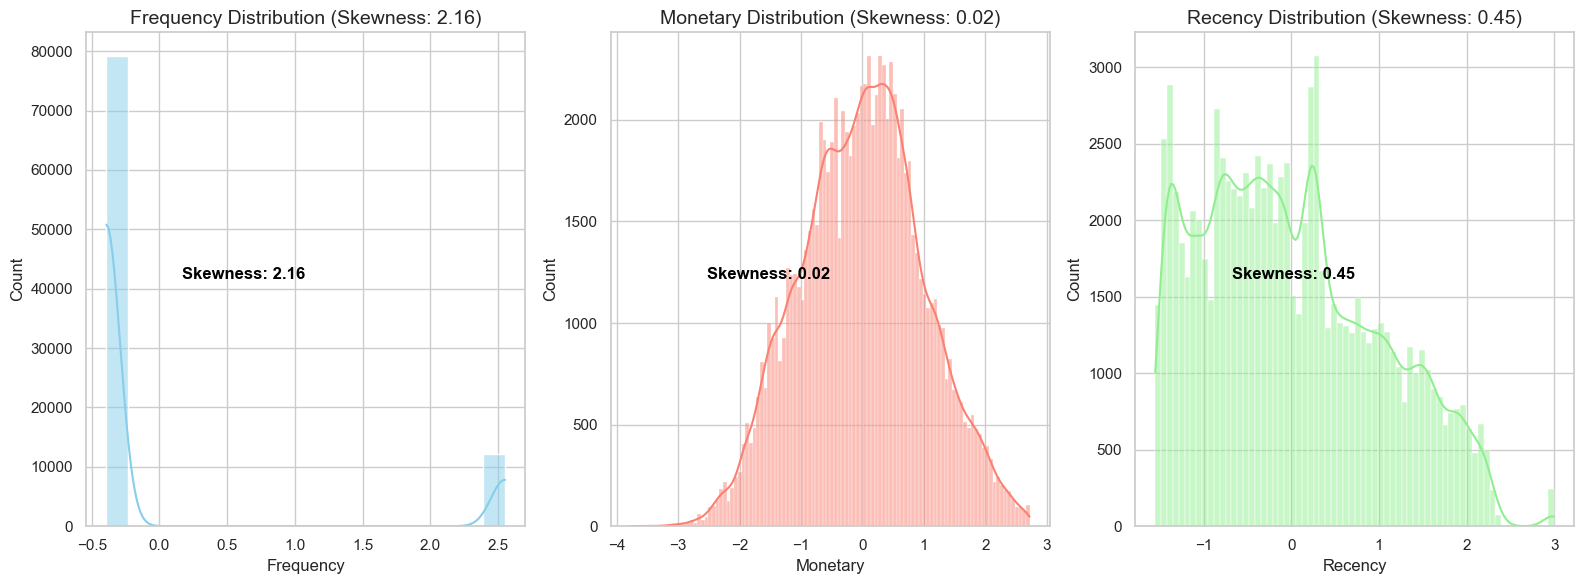

In [367]:
frequency_skew = RMFD_scaled['frequency_log'].skew()
monetary_skew = RMFD_scaled['monetary_log'].skew()
recency_skew = RMFD_scaled['recency'].skew()

sns.set_theme(style='whitegrid')

fig, axes = plt.subplots(1, 3, figsize=(16, 6))

sns.histplot(RMFD_scaled['frequency_log'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title(f'Frequency Distribution (Skewness: {frequency_skew:.2f})', fontsize=14)
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Count')
axes[0].text(0.5, 0.5, f'Skewness: {frequency_skew:.2f}', transform=axes[0].transAxes, horizontalalignment='right', color='black', weight='bold', fontsize=12)

sns.histplot(RMFD_scaled['monetary_log'], kde=True, ax=axes[1], color='salmon')
axes[1].set_title(f'Monetary Distribution (Skewness: {monetary_skew:.2f})', fontsize=14)
axes[1].set_xlabel('Monetary')
axes[1].set_ylabel('Count')
axes[1].text(0.5, 0.5, f'Skewness: {monetary_skew:.2f}', transform=axes[1].transAxes, horizontalalignment='right', color='black', weight='bold', fontsize=12)

sns.histplot(RMFD_scaled['recency'], kde=True, ax=axes[2], color='lightgreen')
axes[2].set_title(f'Recency Distribution (Skewness: {recency_skew:.2f})', fontsize=14)
axes[2].set_xlabel('Recency')
axes[2].set_ylabel('Count')
axes[2].text(0.5, 0.5, f'Skewness: {recency_skew:.2f}', transform=axes[2].transAxes, horizontalalignment='right', color='black', weight='bold', fontsize=12)

plt.tight_layout()
plt.show()

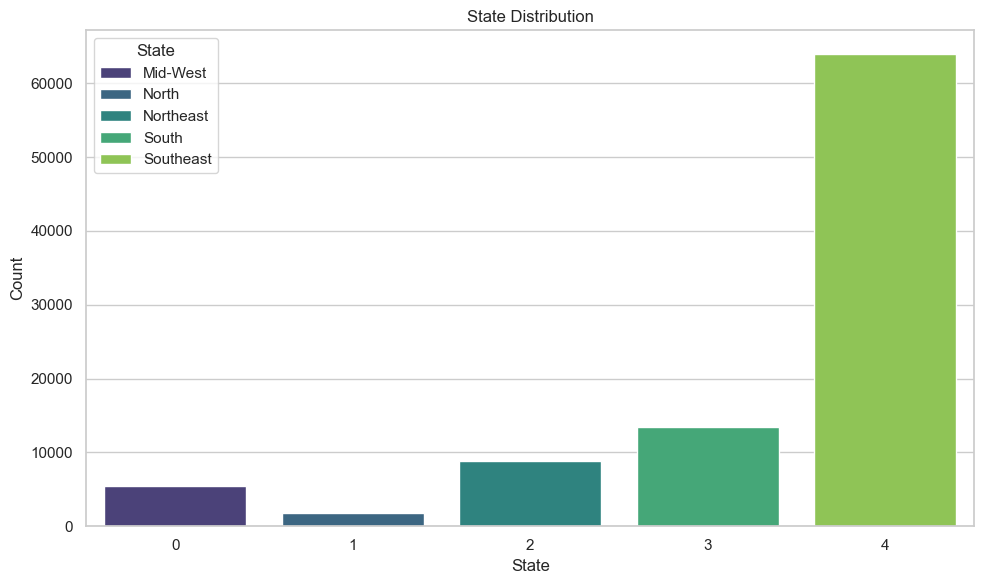

In [368]:
# decode the state
encoded_to_state = {v: k for k, v in state_mapping.items()}

# plot state with legend of each state
plt.figure(figsize=(10, 6))
sns.countplot(x='State', data=state_df, palette='viridis', hue=state_df['State'].map(encoded_to_state))
plt.title('State Distribution')
plt.xlabel('State')
plt.ylabel('Count')
plt.tight_layout()

In [369]:
# merge all features
RMFD_final = pd.concat([RMFD_scaled, state_df], axis=1)

In [370]:
RMFD_final['Code'] = RMFD_final['State'].map(encoded_to_state)

In [371]:
RMFD_final.head()

,recency,frequency_log,monetary_log,State,Code
0,-0.825508,-0.39207,0.315911,4,Southeast
1,-0.805830,-0.39207,-1.926731,4,Southeast
2,1.962187,-0.39207,-0.284618,3,South
3,0.545382,-0.39207,-1.208374,1,North
4,0.328926,-0.39207,0.679511,4,Southeast


In [372]:
# describe RMFD for 1% 5% 10% 25% 50% 75% 90% 95% 99%
RMFD_final.describe([0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).T

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
recency,91393.0,-6.235218e-17,1.000005,-1.553588,-1.501114,-1.409284,-1.284658,-0.812389,-0.123665,0.709364,1.489918,1.844120,2.211439,2.998553
frequency_log,91393.0,-1.313905e-17,1.000005,-0.392070,-0.392070,-0.392070,-0.392070,-0.392070,-0.392070,-0.392070,2.550102,2.550102,2.553157,2.553157
monetary_log,91393.0,-1.290581e-17,1.000005,-3.770397,-2.219329,-1.645390,-1.335044,-0.692353,0.026011,0.667148,1.304477,1.701773,2.277638,2.719009
State,93335.0,3.378658e+00,1.111807,0.000000,0.000000,0.000000,2.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000


In [373]:
# check if RFMD_final has any missing values
RMFD_final.isnull().sum()

recency          1942
frequency_log    1942
monetary_log     1942
State               0
Code                0
dtype: int64

In [374]:
# because the missing values are only from RFM (because of removing RFM outliers), we can safely drop the missing values
RMFD_final.dropna(inplace=True)

In [375]:
# check if RFMD_final has any missing values
RMFD_final.isnull().sum()

recency          0
frequency_log    0
monetary_log     0
State            0
Code             0
dtype: int64

In [376]:
# splitting into numerical and categorical
RFM_numerical = pd.DataFrame(RMFD_final, columns=['recency', 'frequency_log', 'monetary_log'])
RFM_categorical = RMFD_final['State']

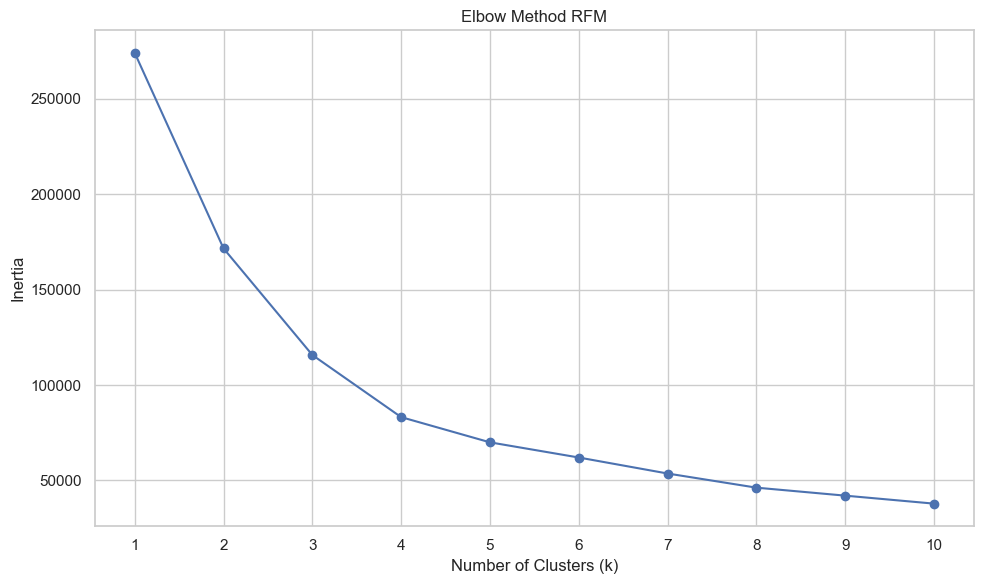

In [377]:
# Elbow method RFM
inertias = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(RFM_numerical)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertias, marker='o')
plt.title('Elbow Method RFM')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(range(1, 11))
plt.grid(True)
plt.tight_layout()
plt.show()

In [378]:
# K-Means menggunakan RFM
# berdasarkan hasil elbow diatas, jumlah kluster yang akan dipilih adalah 4
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(RFM_numerical)

In [379]:
data_with_clusters = RFM_numerical.copy()

cluster_data_with_categorical = pd.concat([data_with_clusters, RMFD_final['State']], axis=1)
cluster_data_with_categorical['Cluster'] = kmeans.labels_

data_with_clusters['Cluster'] = kmeans.labels_

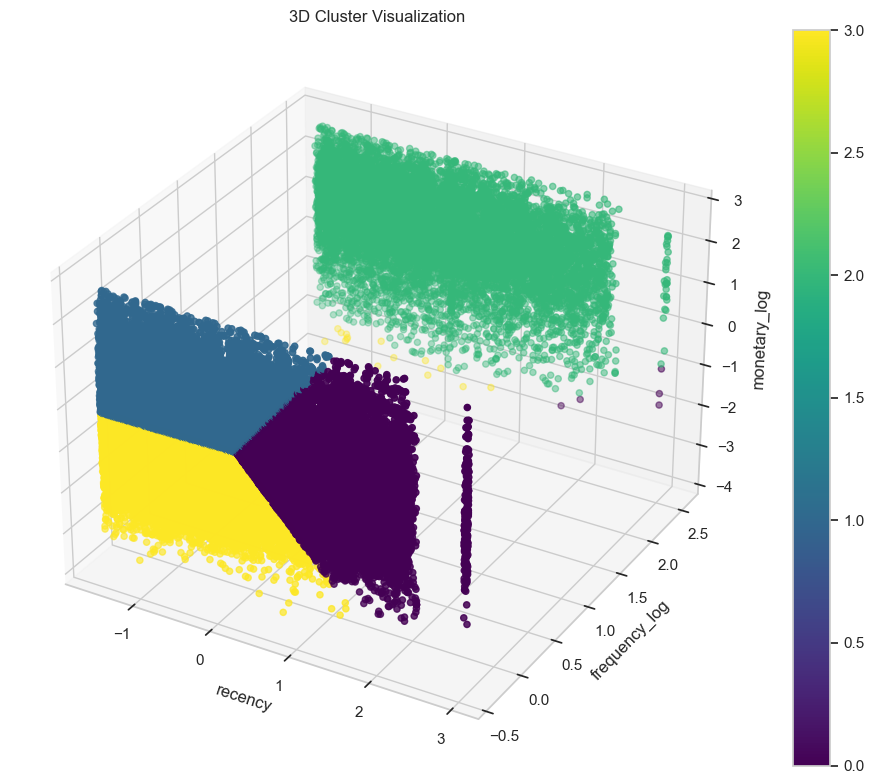

[[ 1.25379119 -0.39144084 -0.14846569]
 [-0.54013899 -0.39207005  0.61627078]
 [ 0.0082292   2.55056429  0.89654482]
 [-0.51126024 -0.39025211 -0.99954836]]

Cluster Summary:
          recency                     frequency_log                      \
             mean       min       max          mean       min       max   
Cluster                                                                   
0        1.252726  0.184621  2.998553     -0.391442 -0.392070  2.553157   
1       -0.538605 -1.553588  1.339055     -0.392070 -0.392070 -0.392070   
2        0.008229 -1.553588  2.998553      2.550564  2.550102  2.553157   
3       -0.513801 -1.553588  1.522715     -0.390252 -0.392070  2.553157   

        monetary_log                      
                mean       min       max  
Cluster                                   
0          -0.151172 -2.978159  2.712028  
1           0.617987 -0.207492  2.719009  
2           0.896545 -2.450576  2.718529  
3          -0.998410 -3.770397 -0.183086 

In [380]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(data_with_clusters.iloc[:, 0],
                     data_with_clusters.iloc[:, 1],
                     data_with_clusters.iloc[:, 2],
                     c=clusters,
                     cmap='viridis')

ax.set_xlabel(data_with_clusters.columns[0])
ax.set_ylabel(data_with_clusters.columns[1])
ax.set_zlabel(data_with_clusters.columns[2])
plt.title('3D Cluster Visualization')
plt.colorbar(scatter)
plt.tight_layout()
plt.show()

print(kmeans.cluster_centers_)

cluster_summary = data_with_clusters.groupby('Cluster').agg({
    RFM_numerical.columns[0]: ['mean', 'min', 'max'],
    RFM_numerical.columns[1]: ['mean', 'min', 'max'],
    RFM_numerical.columns[2]: ['mean', 'min', 'max']
})

print("\nCluster Summary:")
print(cluster_summary)

In [381]:
# cluster summary
def cluster_summary(df):
    cluster_size = df['Cluster'].value_counts().sort_index()
    total_samples = len(df)
    percentages = ((cluster_size / total_samples) * 100).round(2)
    
    summary = df.groupby('Cluster').agg({
        **{col: ['mean'] for col in df.columns if col != 'Cluster' and col != 'State'}
    })
    
    # Add count and percentage columns
    summary['Number of Customer'] = cluster_size
    summary['Percentage (%)'] = percentages
    
    # print state
    state_summary = df.groupby('Cluster')['State'].value_counts().unstack().fillna(0)
    # use state_mapping to decode the state
    state_summary.columns = state_summary.columns.map(encoded_to_state)
    
    summary = pd.concat([summary, state_summary], axis=1)
    
    # rename columns
    summary.columns = ['Mean R', 'Mean F', 'Mean M', 'Number of Customer', 'Percentage (%)'] + list(state_summary.columns)
    
    return summary

In [382]:
# display cluster unique values on cluster with categorical
cluster_summary(cluster_data_with_categorical)

,Mean R,Mean F,Mean M,Number of Customer,Percentage (%),Mid-West,North,Northeast,South,Southeast
Cluster,,,,,,,,,,
0,1.252726,-0.391442,-0.151172,23410,25.61,1343,459,2209,3433,15966
1,-0.538605,-0.392070,0.617987,29930,32.75,1774,552,2808,4209,20587
2,0.008229,2.550564,0.896545,12156,13.30,745,199,1158,1762,8292
3,-0.513801,-0.390252,-0.998410,25897,28.34,1462,495,2453,3706,17781


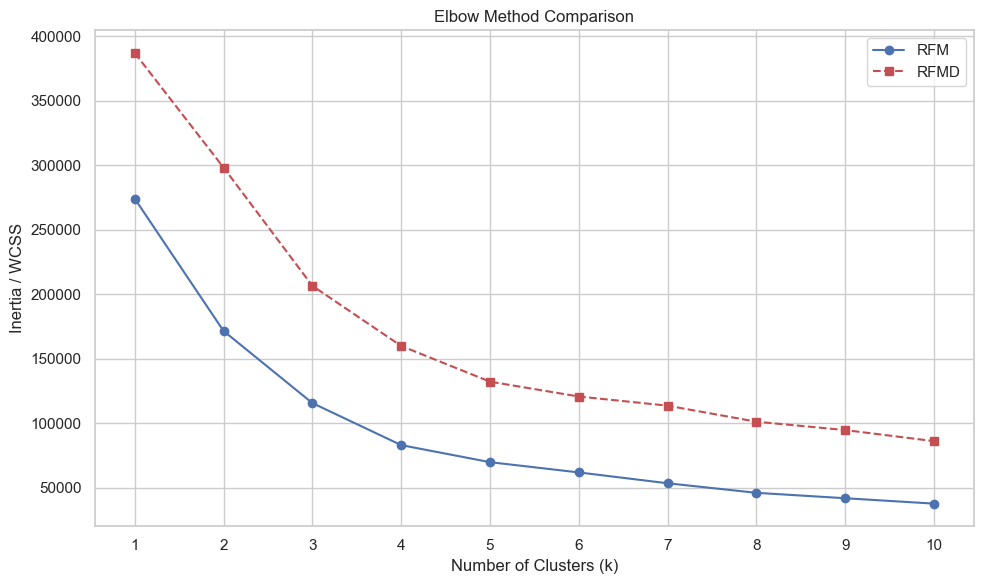

In [383]:
# Elbow method RFMD

#ilangin column Code
RMFD_numerical = RMFD_final.drop(columns=['Code'])

wcss = []
cluster_range = range(1, 11)
for i in cluster_range:
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(RMFD_numerical)
    wcss.append(kmeans.inertia_)

# Elbow method RFM
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

RFM_numerical = pd.DataFrame(RMFD_final, columns=['recency', 'frequency_log', 'monetary_log'])
inertias = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(RFM_numerical)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))

plt.plot(cluster_range, inertias, marker='o', linestyle='-', color='b', label='RFM')
plt.plot(cluster_range, wcss, marker='s', linestyle='--', color='r', label='RFMD')

plt.title('Elbow Method Comparison')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia / WCSS')
plt.xticks(cluster_range)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [384]:
# # K prototype using RFMD
# 
# #ambil column numeric dan categoric
# 
# numb_columns = ['recency', 'frequency_log', 'monetary_log', 'State']
# cat_column = ['Code']
# 
# X = RMFD_final[numb_columns + cat_column].to_numpy()
# 
# # testing
# X_sample = RMFD_final.sample(10, random_state=42) 
# 
# cat_indices = [X_sample.shape[1] - 1]
# 
# cost = []
# cluster_range = range(2, 6)
# 
# for k in cluster_range:
#     kproto = KPrototypes(n_clusters=k, random_state=42)
#     # kproto = KPrototypes(n_clusters=k, random_state=42, n_init=3, max_iter=20)
#     kproto.fit(X, categorical=cat_indices)
#     cost.append(kproto.cost_)
# 
# # Plot
# plt.figure(figsize=(10, 6))
# plt.plot(cluster_range, cost, marker='o')
# plt.title('Elbow Method for K-Prototypes')
# plt.xlabel('Number of Clusters')
# plt.ylabel('Cost')
# plt.show()

In [385]:
# Setelah dapet cluster yg bagus dari atas